<a href="https://colab.research.google.com/github/SergeiVKalinin/MLSTEM2024/blob/main/Day5/Day5_gpax_viDKL_plasmons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if os.environ.get("CI_SMOKE"):
    SMOKE = True
else:
    SMOKE = False

# Deep kernel learning for data reconstruction and automated experiment

*Prepared by Maxim Ziatdinov (January 2022). Last updated in October 2023.*

This notebook demonstrates how to use deep kernel learning (DKL) for data reconstruction and automated experiments. We will be using a pre-acquired STEM-EELS experimental dataset on plasmonic nanoparticles from Kevin Roccapriore.

The DKL can be viewed as an extension of Gaussian process (GP) for high-dimensional data. Hence, we first briefly overview the standard GP. GP is a powerful tool for reconstructing with quantified uncertainty an unknown  (“black-box”) function  over a low-dimensional parameter space. Formally, given a set of observed data points $(x_i, y_i)_{i=1, ..., N}$ and assuming normally distributed observation noise $𝜀$, the GP can be defined as

$$y_i= f(x_i) + 𝜀_i$$
$$f ∼ MVN(0; K(x_i, x_j))$$

where $MVN$ stands for Multivariate Normal Distribution, $K$ is a kernel function,  and $f(x)$ is a "black-box" function we try to reconstruct. The functional form of the kernel $K$ is chosen prior to the experiment, and its hyperparameters are inferred from the observations using either Markov chain Monte Carlo methods or stochastic variational inference.

Once the GP model is trained, we can use it to make a probabilistic prediction on new inputs. Specifically, the predictive mean and covariance on the new data $X_*$ are given by

$$𝜇_*=K(X_*,X|𝜃)K(X,X|𝜃)^{-1}y$$
$$𝛴_*=K(X_*,X_*|𝜃)-K(X_*,X|𝜃)K(X,X|𝜃)^{-1}K(X,X_*|𝜃)$$

where 𝜃 are learned GP kernel parameters. Note that we absorbed model noise into the computation of kernel function. The predictive uncertainty is given by the square root of the diagonal elements of the covariance matrix $U_*=\sqrt{\text{diag}(𝛴_*)}$.

The GP predictive mean and uncertainty can then be used to derive an acquisition function for selecting the next point to measure. Depending on the form of acqusition function, this can be referred to as active learning (discovering the overall data distribution) or Bayesian optimization (identifying global maximum or minimum). Here, we will refer to both of them as "active learning."

A significant limitation of the standard GP (and GP-based active learning) is that it does not scale well with the dimensionality of the parameter space. Another limitation is that the standard GP
does not, strictly speaking, learn representations of data which precludes us from using information from different experimental modalities to assist in selecting the next measurement point.

To address these issues, we have adapted a [deep kernel learning](https://arxiv.org/abs/1511.02222) (DKL) approach. DKL can be understood as a hybrid of deep neural network (DNN) and GP. The DNN serves as a feature extractor that allows reducing the complex high-dimensional features to low-dimensional descriptors on which a standard GP kernel operates. The parameters of DNN and GP kernel are inferred jointly in an end-to-end fashion. Practically, the DKL training inputs are usually patches from an (easy-to-acquire) structural image over a large field of view, and training targets represent a physical property of interest derived from the (hard-to-acquire) spectra measured in those patches. The DKL output on the new inputs (image patches for which there are no measured spectra) is the expected property value and associated uncertainty, which can be used to derive the next measurement point in the automated experiments.

Formally, we define a deep kernel as

$$k_{DKL}(x_i,x_j|w,𝜃)=k_{base}(g(x_i|w),g(x_j|w)|𝜃)$$

where $g$ is a neural network with weights $w$ and $k_{base}$ is a standard GP kernel. The parameters of neural network and GP base
kernel are learned simultaneously via Markov chain Monte Carlo sampling techniques or a stochastic variational inference. The trained DKL model is then used for obtaining predictive mean and uncertainty and deriving the acquisition function the same way as for the standard GP.

GPax package has the fully Bayesian DKL (weights of neural network and GP hyperparameters are inferred using Hamiltonian Monte Carlo) and the Variational Inference approximation of DKL, viDKL. The fully Bayesian DKL can provide an asymptotically exact solution but is too slow for most automated experiments. Hence, for the latter, we use the viDKL.

## Install & Import

Install the latest GPax package from PyPI (this is best practice, as it installs the latest, deployed and tested version).

In [ ]:
!pip install gpax
!pip install atomai  # we will use the atomai's utility function for preparing the input data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.

Import needed packages:

In [ ]:
try:
    # For use on Google Colab
    import gpax

except ImportError:
    # For use locally (where you're using the local version of gpax)
    print("Assuming notebook is being run locally, attempting to import local gpax module")
    import sys
    sys.path.append("..")
    import gpax

In [ ]:
from warnings import filterwarnings

import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

from atomai.utils import get_coord_grid, extract_patches_and_spectra

gpax.utils.enable_x64()

filterwarnings("ignore", module="haiku._src.data_structures")

Enable some pretty plotting.

In [ ]:
import matplotlib as mpl

In [ ]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 200

## Prepared data

Download training data:

In [ ]:
!wget -qq https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

Load data into the notebook:

In [ ]:
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key, value in loadedfile.items():
  print(key, value.shape)

image (62, 75)
spectrum image (62, 75, 1496)
energy axis (1496,)
scale ()


In [ ]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

Generate training inputs (image patches) and targets (spectra)



In [ ]:
window_size = 16

coordinates = get_coord_grid(img, step=1, return_dict=False)
features, targets, indices = extract_patches_and_spectra(
    specim,
    img,
    coordinates=coordinates,
    window_size=window_size,
    avg_pool=16
)

features.shape, targets.shape

/usr/local/lib/python3.10/dist-packages/atomai/utils/img.py:450: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  spectra = torch.tensor(spectra).unsqueeze(1)


((2820, 16, 16), (2820, 93))

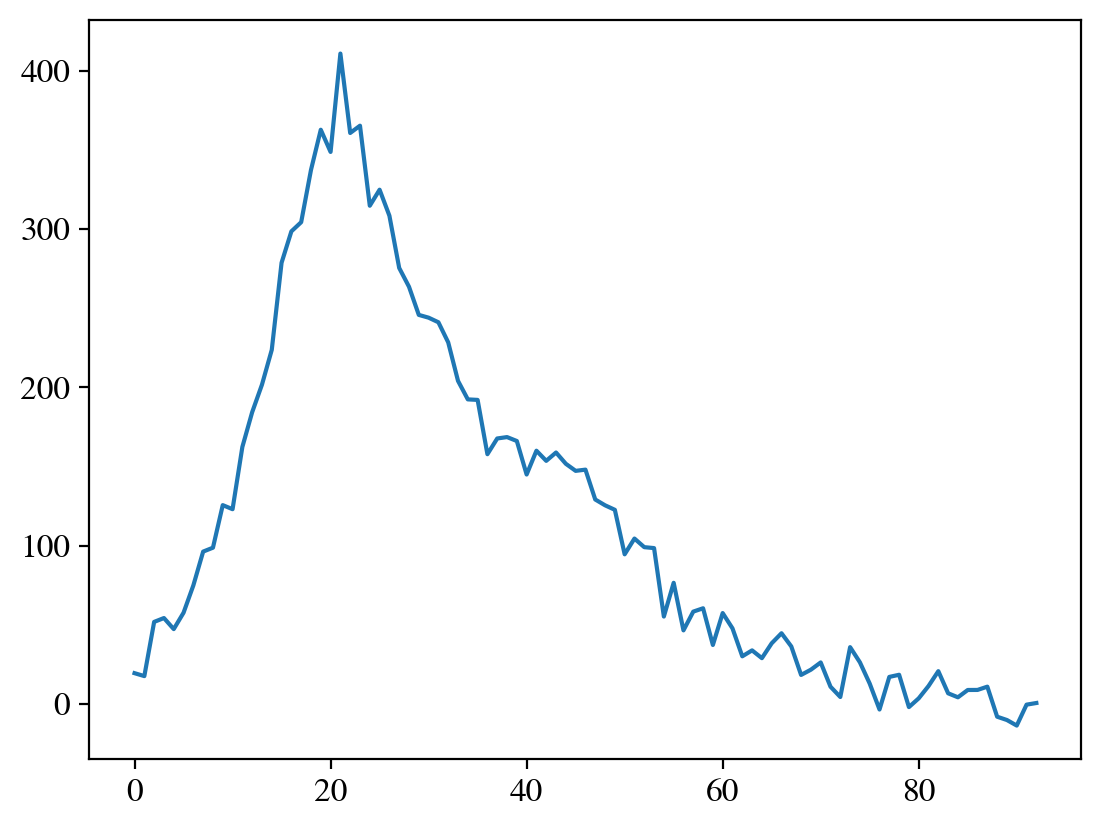

In [ ]:
#plt.imshow(features[34,:,:])
plt.plot(targets[456,:])

Normalize data:

In [ ]:
norm_ = lambda x: (x - x.min()) / x.ptp()
features, targets = norm_(features), norm_(targets)

### Scalarizer
Next, we select a scalarizer function that will convert a measured spectrum into a scalar physical descriptor. The scalarizer defines the measure of physical interest to the response and acts as a reward towards the specific behavior in the experiment. The scalarizer can be created in almost unlimited number of ways. For example, it can be based
on the gross characteristic of the spectrum, such as area under curve, integrated intensity within certain energy range, area or width of hysteresis loop, etc. It can incorporate the physical model and physics-based analysis, for example converting predicted spectrum to specific materials parameters. It can be based on hybrid criteria defined via combinations of functional fits, decision trees, etc. Finally, it can be crowd sourced – if the neural network has been trained by human labelled data, or other form of expert system can be used. Ultimately however, the scalarizer should define the measure of physical interest much like the human operator would do.

Let's scalarize our vactor-valued targets. Here we are going to do the scalarization by simply using the intensity of the most prominent plasmonic peak, but more sophisticated scalar descritpors can be derived as well (ratio of peaks, etc.). First, let's do it for a single spectrum:

25 0.2826059331244979


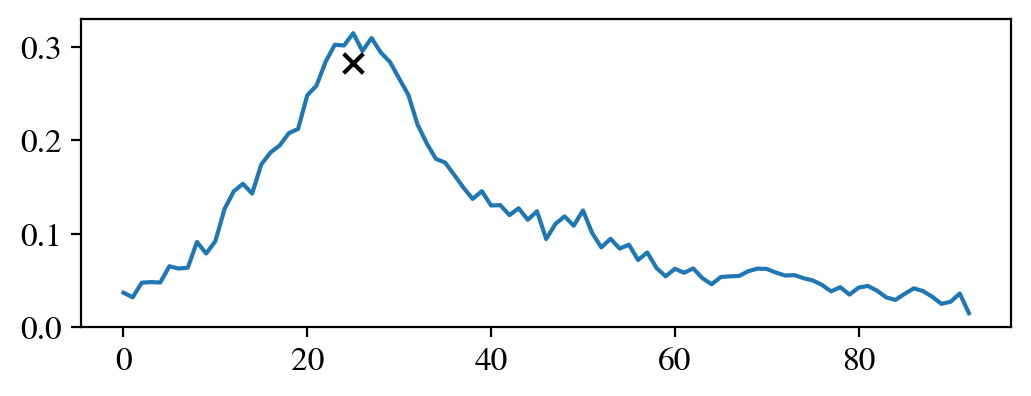

In [ ]:
k = 1
peak_data = find_peaks(targets[k], width=5)
peak_pos, peak_int = peak_data[0][0], peak_data[1]['prominences'][0]

fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(targets[k], zorder=0)
print(peak_pos, peak_int)
ax.scatter(peak_pos, peak_int, marker='x', s=50, c='k', zorder=1)
plt.show()

Now for all the data:

In [ ]:
peaks_all, features_all, indices_all = [], [], []
for i, t in enumerate(targets):
    peak = find_peaks(t, width=5)[1]["prominences"]
    if len(peak) == 0:
        continue
    peaks_all.append(np.array([peak[0]]) if len(peak) > 1 else peak)
    features_all.append(features[i])
    indices_all.append(indices[i])
peaks_all = np.concatenate(peaks_all)
features_all = np.array(features_all)
indices_all = np.array(indices_all)

Plot the scalarized target values for each feature coordinate:

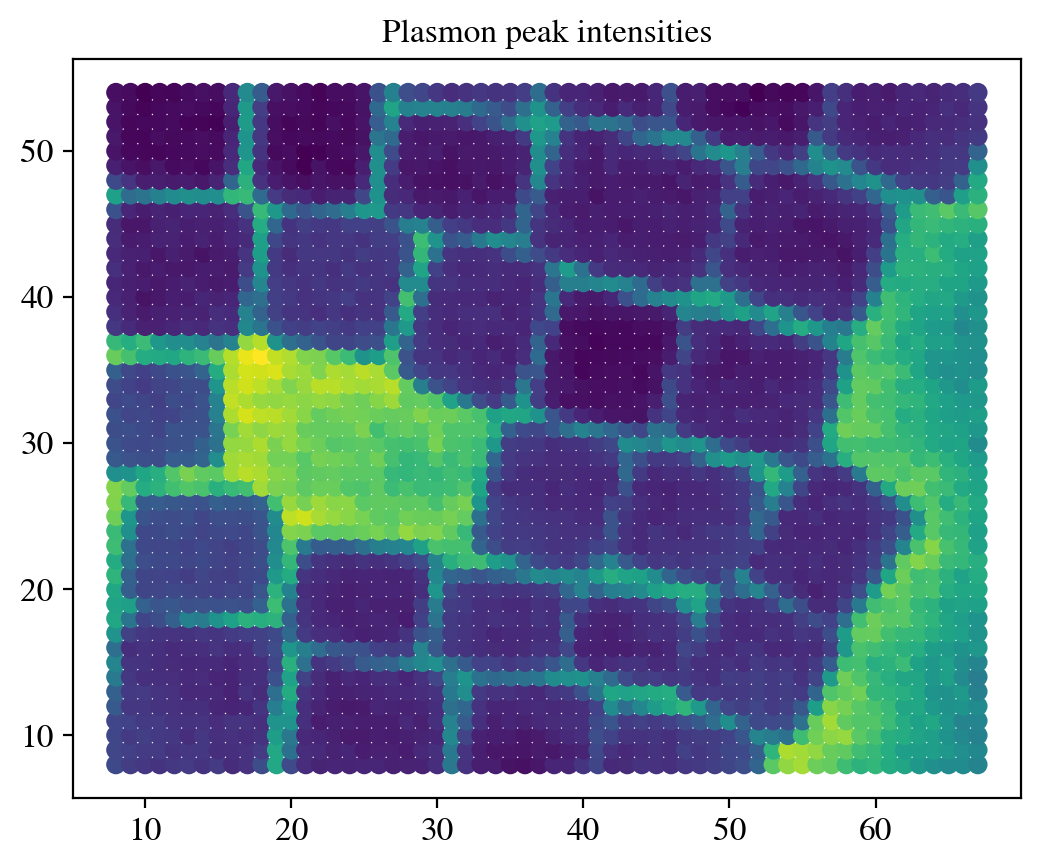

In [ ]:
_, ax = plt.subplots()
ax.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all)
ax.set_title('Plasmon peak intensities')
ax.set_aspect('equal')
plt.show()

## Reconstruction from partial data
Here we demonstrate how to use DKL to learn a correlative structure-property relationship from a relatively small number of image-(scalarized)spectrum pairs and then use the trained model to predict a targeted physical property for the entire image space.

Prepare data:

In [ ]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

Split the data in such a way that we use only a relatively small part of data (to the left of the vertical dashed line in the figure below) to train a DKL model and then use the trained model to make a prediction of the "unmeasured" plasmon peak values (the part to the right of the vertical dashed line):

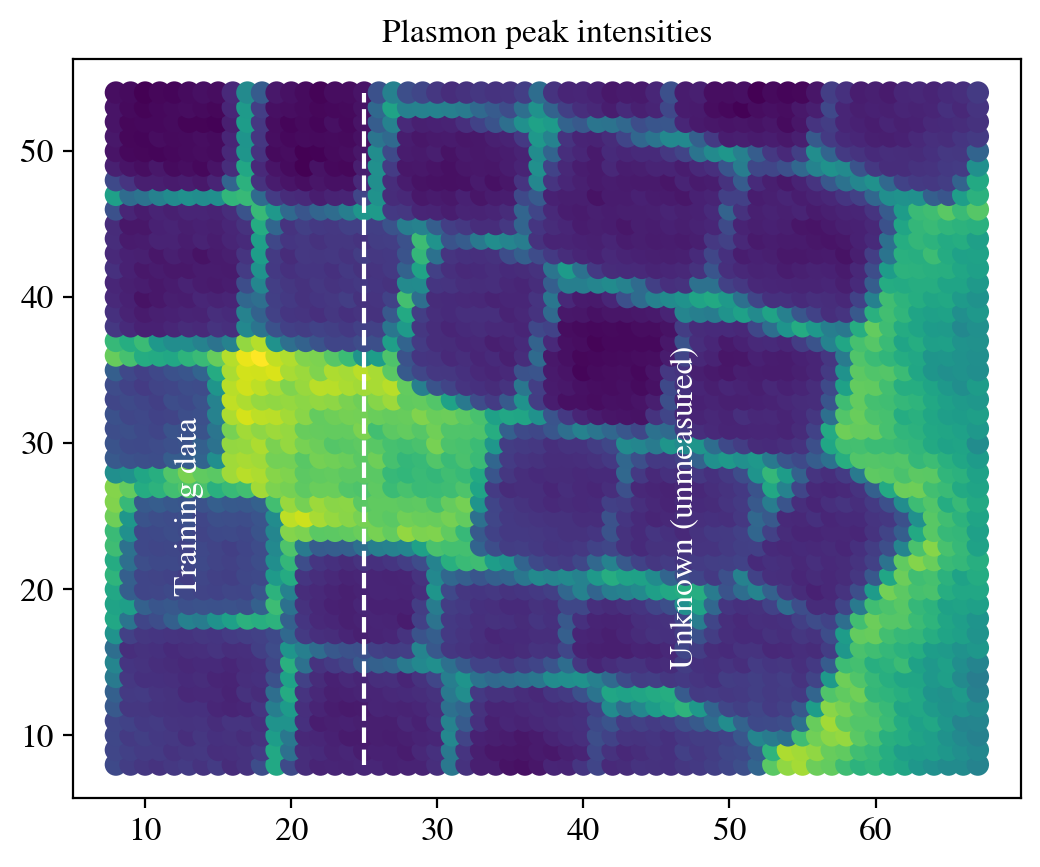

In [ ]:
split_ = 25
X_train = X[indices_all[:, 1] < split_]
y_train = y[indices_all[:, 1] < split_]
indices_train = indices_all[indices_all[:, 1] < split_]

_, ax = plt.subplots()
ax.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax.text(split_ // 2, 20, 'Training data', c='w', size=12, rotation=90)
ax.text((split_ + indices[:, 1].max()) // 2, 15, 'Unknown (unmeasured)', c='w', size=12, rotation=90)
ax.set_title('Plasmon peak intensities');
ax.set_aspect('equal')
plt.show()

Initialize and train a DKL model:

In [ ]:
data_dim = X_train.shape[-1]

key1, key2 = gpax.utils.get_keys()

dkl = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
dkl.fit(key1, X_train, y_train, num_steps=100, step_size=0.05)

100%|██████████| 100/100 [00:02<00:00, 44.67it/s, init loss: 21019.9002, avg. loss [96-100]: 18367.9124]



Inferred GP kernel parameters
k_length         [25.4059 21.6448]
k_scale          0.1655
noise            0.0123


Use the trained model to make a probabilsitic prediction for all the image patches:

In [ ]:
mean, var = dkl.predict(key2, X)

Visualize predictive mean and uncertainty:

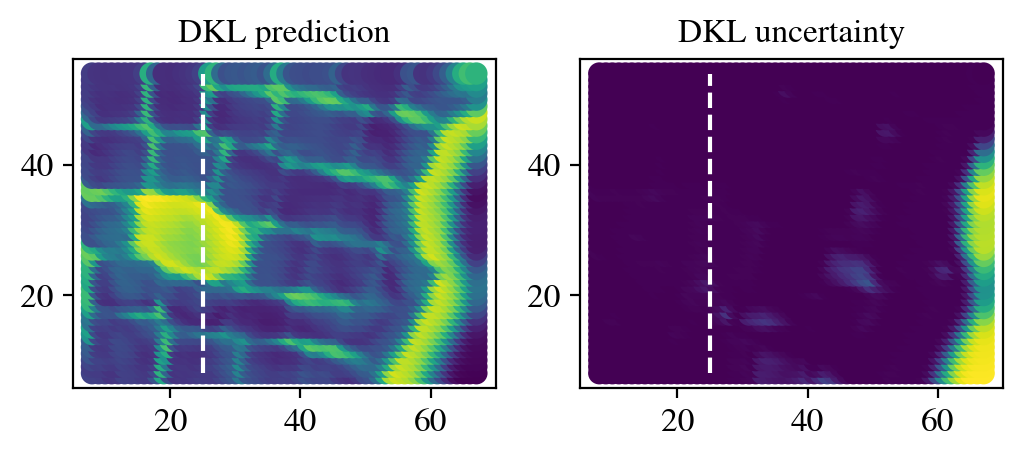

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 5))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=mean)
ax1.set_title("DKL prediction")
ax2.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=var)
ax2.set_title("DKL uncertainty")
ax1.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax2.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
for _ax in fig.axes:
    _ax.set_aspect('equal')
plt.show()

We can also visualize the latent/embedding space:

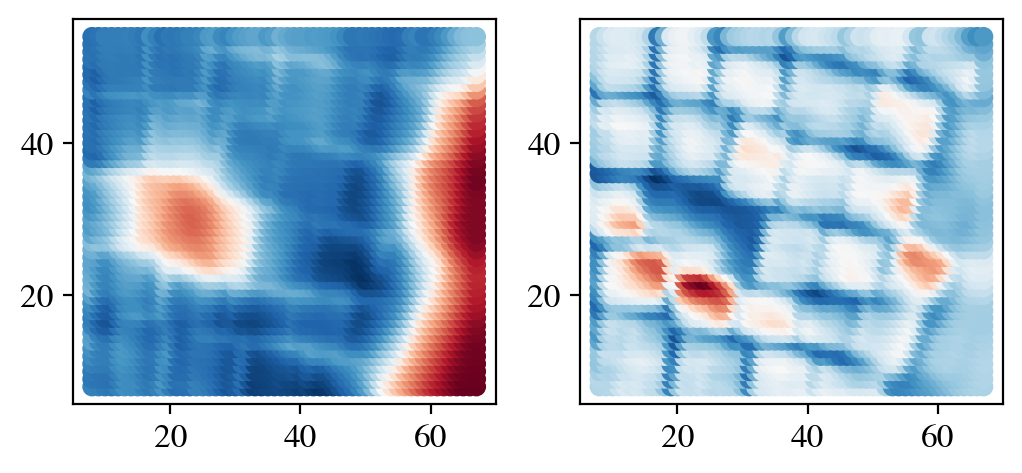

In [ ]:
embeded = dkl.embed(X)
embeded = embeded / embeded.max()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 0], cmap='RdBu')
ax2.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 1], cmap='RdBu')
plt.show()

## Active learning
Now we are going to use DKL to actively learn (local) structures where a particular physical behavior or property (here, plasmon resonance peak) is maximized. Starting with just a few "measured" point, we use DKL to obtain predictive mean and variance for our property of interest over the entire parameter space, and then use them to compute the upper confedence bound (UCB) acquisition function for sampling the next measurement point.

Prepare the data

In [ ]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

Get the initial measurements aka training points. Here ```X_measured``` are the already measured points, that is, the image patches for which there are measured spectra, whose scalarized values are stored in ```y_measured```. The ```X_unmeasured``` are unmeasured points, that is, image patches for which there are yet no measured spectra.

In [ ]:
# use only 0.02% of grid data points as initial training points
(
    X_measured,
    X_unmeasured,
    y_measured,
    y_unmeasured,
    indices_measured,
    indices_unmeasured
) = train_test_split(
    X,
    y,
    indices_all,
    test_size=0.998,
    shuffle=True,
    random_state=1
)

seed_points = len(X_measured)

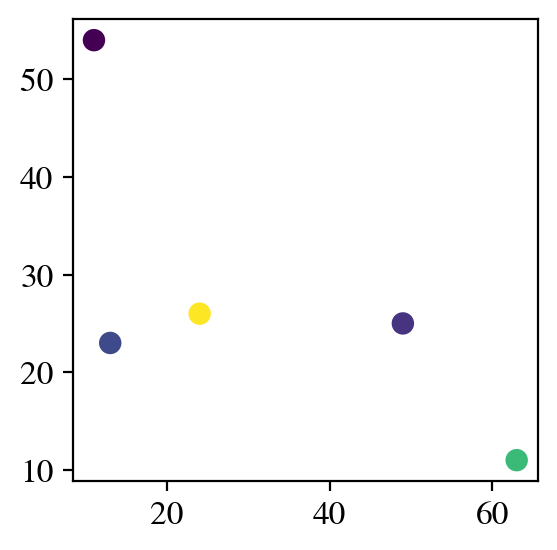

In [ ]:
plt.figure(figsize=(3, 3))
plt.scatter(indices_measured[:, 1], indices_measured[:, 0], s=50, c=y_measured)
plt.show()

Do sample exploration based on the pre-acquired data (i.e., we are running a "dummy" experiment):

In [ ]:
def plot_result(indices, obj):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.scatter(indices[:, 1], indices[:, 0], s=32, c=obj, marker='s')
    next_point = indices[obj.argmax()]
    ax.scatter(next_point[1], next_point[0], marker='x', c='k')
    ax.set_title("Acquisition function values")
    plt.show()

1/80


100%|██████████| 100/100 [00:01<00:00, 64.27it/s, init loss: 20124.5998, avg. loss [96-100]: 19061.5936]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.2994
noise            0.1452


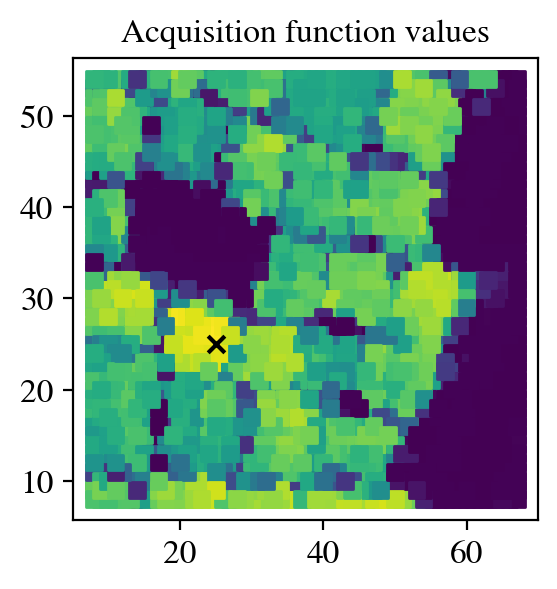

2/80


100%|██████████| 100/100 [00:01<00:00, 52.49it/s, init loss: 20126.0083, avg. loss [96-100]: 19062.0954]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3185
noise            0.1395


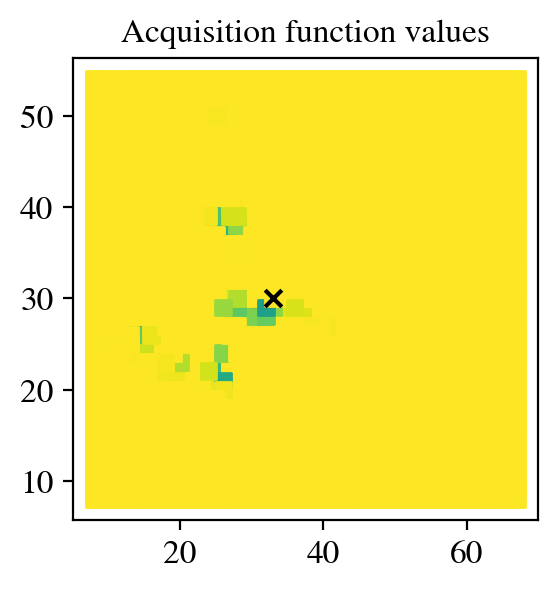

3/80


100%|██████████| 100/100 [00:01<00:00, 61.50it/s, init loss: 20127.3757, avg. loss [96-100]: 19062.2404]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3296
noise            0.1231


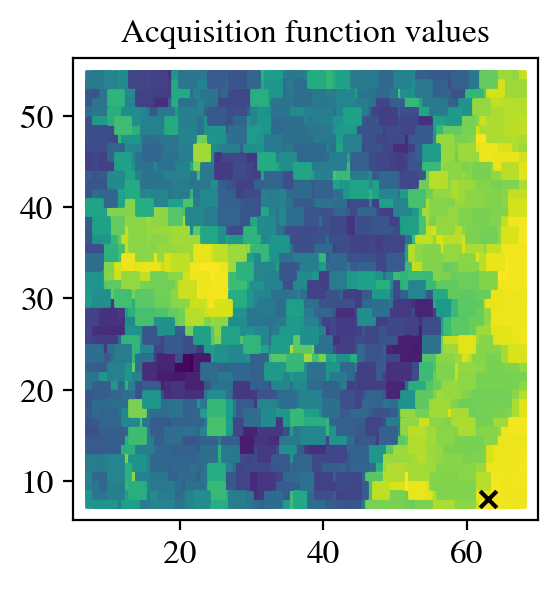

4/80


100%|██████████| 100/100 [00:01<00:00, 63.76it/s, init loss: 20128.6647, avg. loss [96-100]: 19062.1365]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33290000000000003
noise            0.10550000000000001


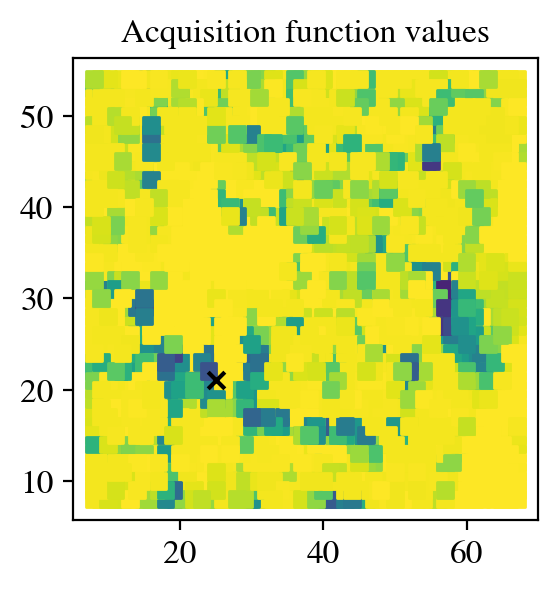

5/80


100%|██████████| 100/100 [00:01<00:00, 64.21it/s, init loss: 20129.9213, avg. loss [96-100]: 19062.3020]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3216
noise            0.10210000000000001


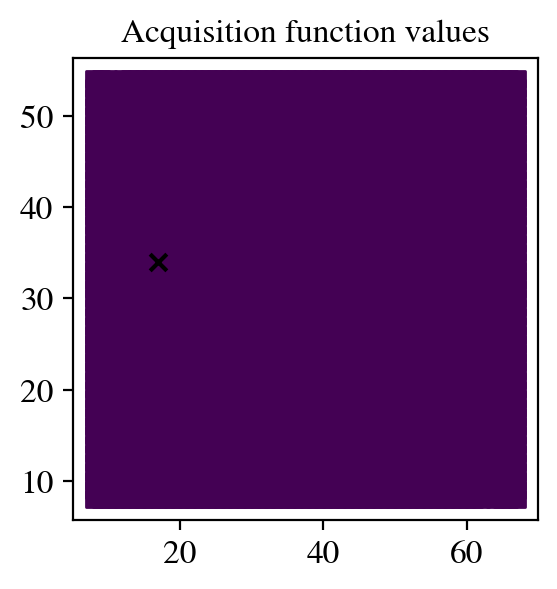

6/80


100%|██████████| 100/100 [00:01<00:00, 61.36it/s, init loss: 20131.3796, avg. loss [96-100]: 19062.9604]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33630000000000004
noise            0.1082


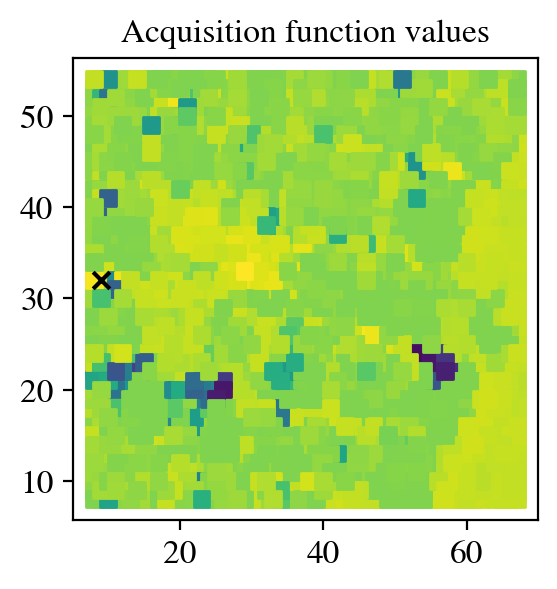

7/80


100%|██████████| 100/100 [00:02<00:00, 35.85it/s, init loss: 20132.6486, avg. loss [96-100]: 19062.9755]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.32930000000000004
noise            0.1017


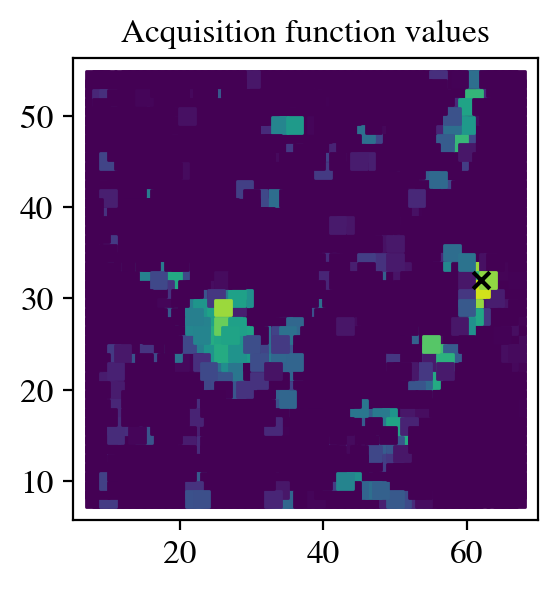

8/80


100%|██████████| 100/100 [00:01<00:00, 61.04it/s, init loss: 20134.0015, avg. loss [96-100]: 19062.8774]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3336
noise            0.0937


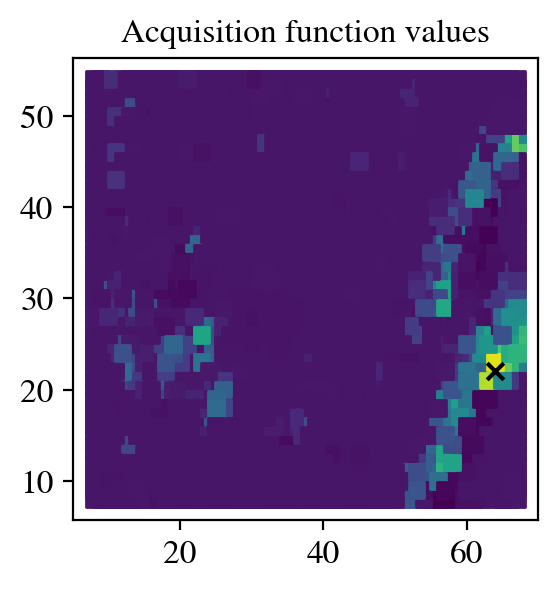

9/80


100%|██████████| 100/100 [00:02<00:00, 47.88it/s, init loss: 20135.3050, avg. loss [96-100]: 19062.9871]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.34090000000000004
noise            0.0906


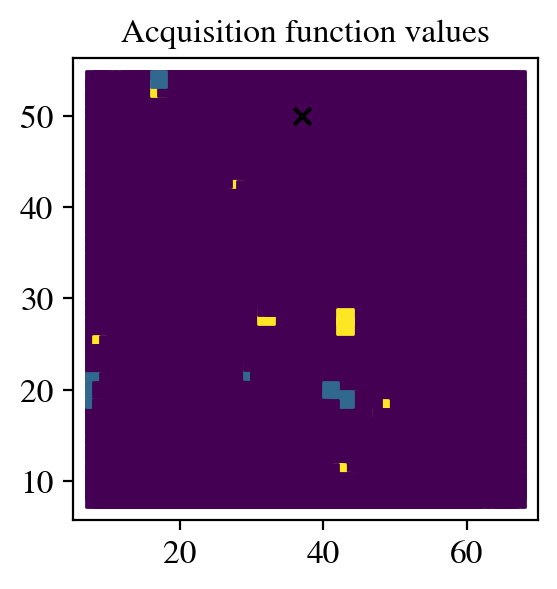

10/80


100%|██████████| 100/100 [00:01<00:00, 55.13it/s, init loss: 20136.6187, avg. loss [96-100]: 19062.6985]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.34090000000000004
noise            0.0833


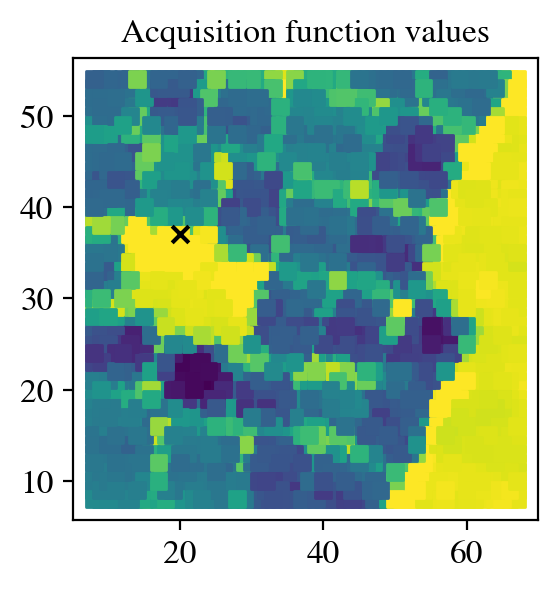

11/80


100%|██████████| 100/100 [00:02<00:00, 48.03it/s, init loss: 20137.9123, avg. loss [96-100]: 19062.4322]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3385
noise            0.0779


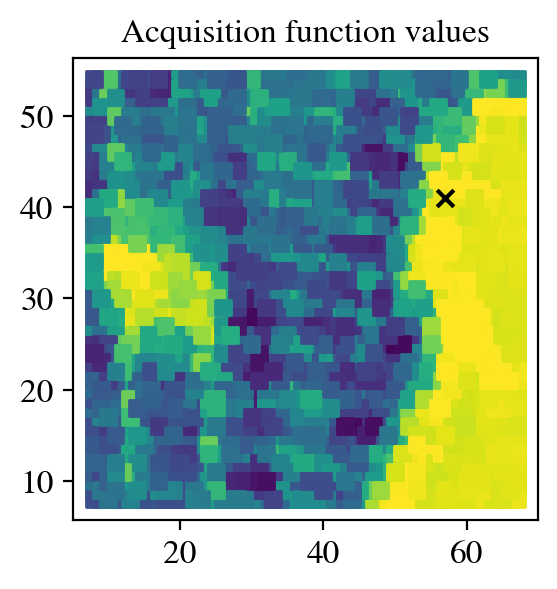

12/80


100%|██████████| 100/100 [00:01<00:00, 60.94it/s, init loss: 20139.0886, avg. loss [96-100]: 19062.6813]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33140000000000003
noise            0.0789


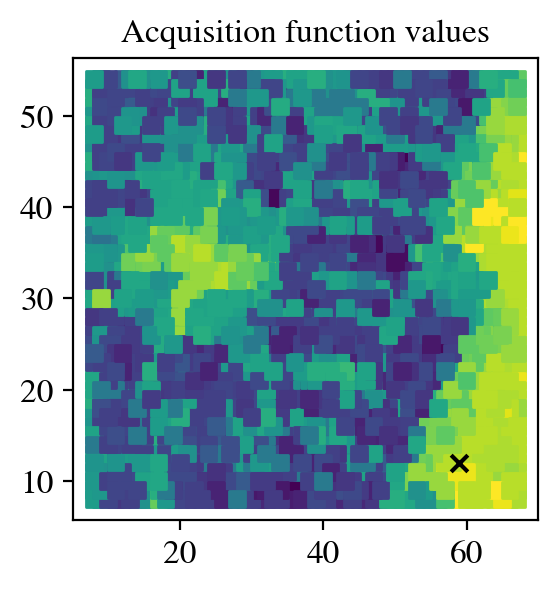

13/80


100%|██████████| 100/100 [00:01<00:00, 55.73it/s, init loss: 20140.4796, avg. loss [96-100]: 19062.6875]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3365
noise            0.0771


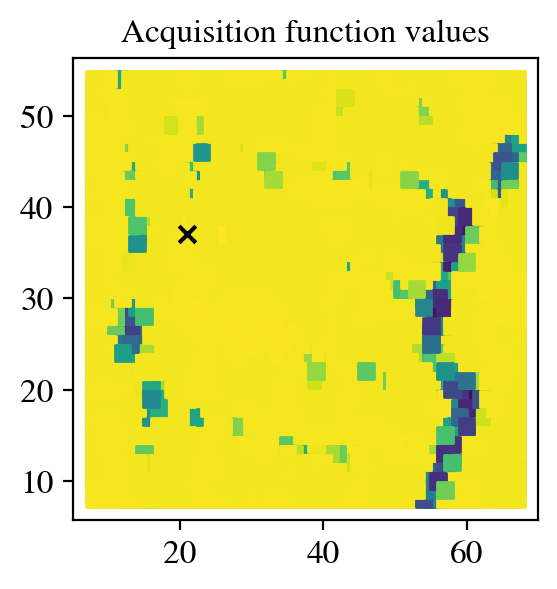

14/80


100%|██████████| 100/100 [00:01<00:00, 59.93it/s, init loss: 20141.7223, avg. loss [96-100]: 19062.4510]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33380000000000004
noise            0.0736


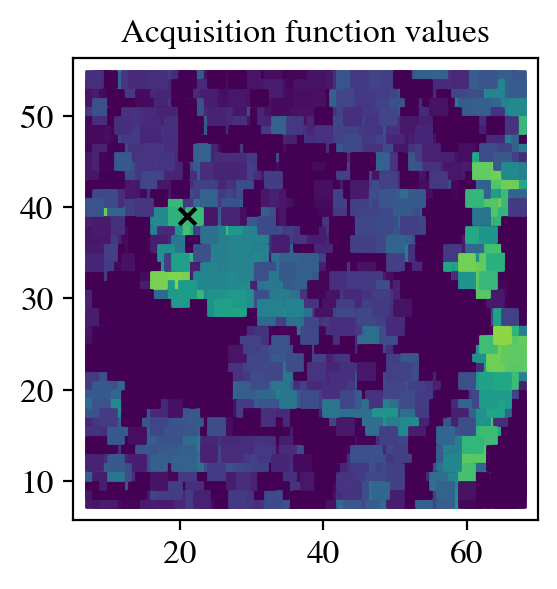

15/80


100%|██████████| 100/100 [00:01<00:00, 52.40it/s, init loss: 20142.9241, avg. loss [96-100]: 19062.5160]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3289
noise            0.0731


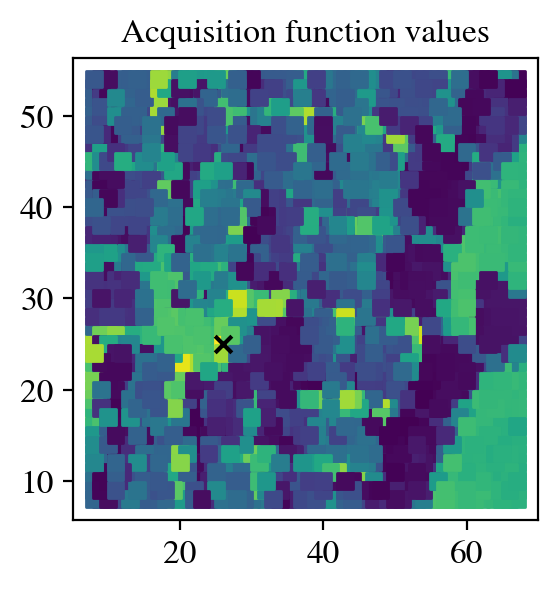

16/80


100%|██████████| 100/100 [00:01<00:00, 53.69it/s, init loss: 20144.3148, avg. loss [96-100]: 19062.5695]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3336
noise            0.0724


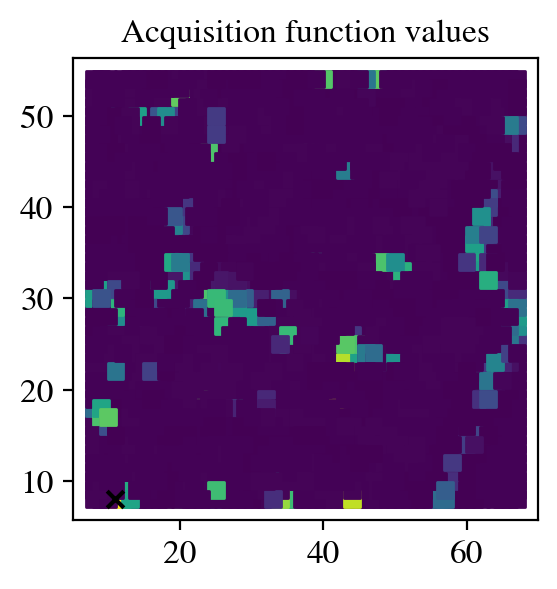

17/80


100%|██████████| 100/100 [00:01<00:00, 53.81it/s, init loss: 20145.5344, avg. loss [96-100]: 19062.6462]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.329
noise            0.0722


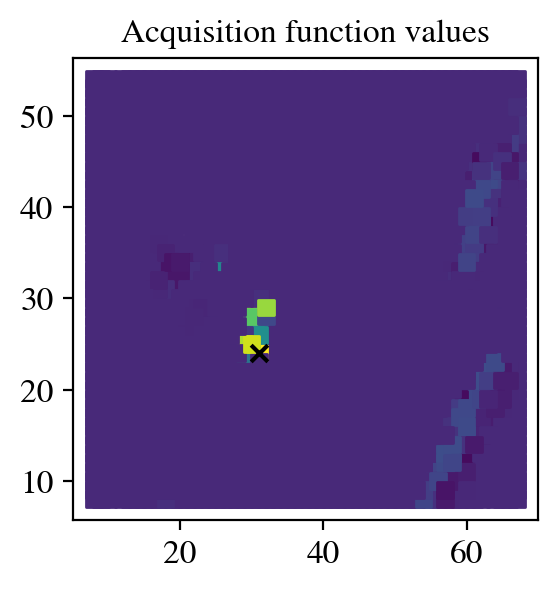

18/80


100%|██████████| 100/100 [00:01<00:00, 52.35it/s, init loss: 20146.9213, avg. loss [96-100]: 19062.7136]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33330000000000004
noise            0.0717


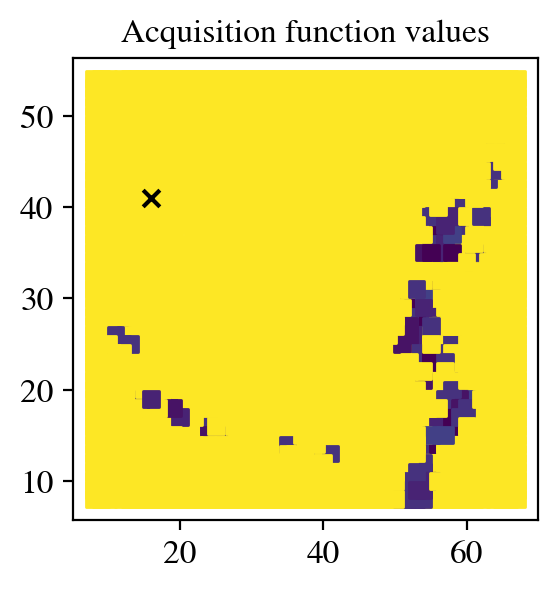

19/80


100%|██████████| 100/100 [00:01<00:00, 54.58it/s, init loss: 20148.1695, avg. loss [96-100]: 19062.9715]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3284
noise            0.0728


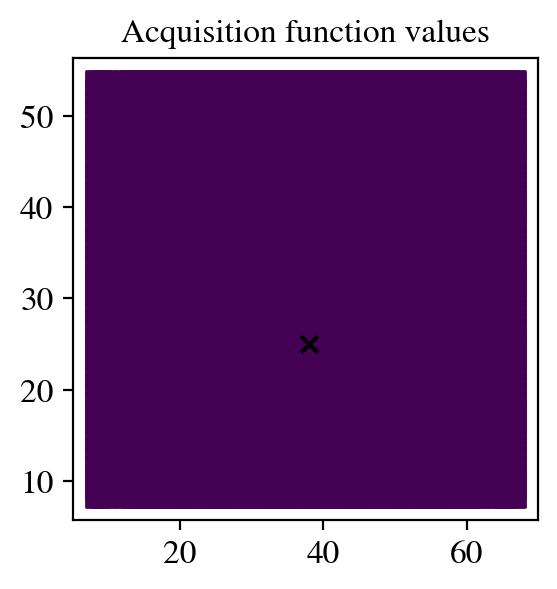

20/80


100%|██████████| 100/100 [00:02<00:00, 42.98it/s, init loss: 20149.3475, avg. loss [96-100]: 19063.0054]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.32480000000000003
noise            0.07250000000000001


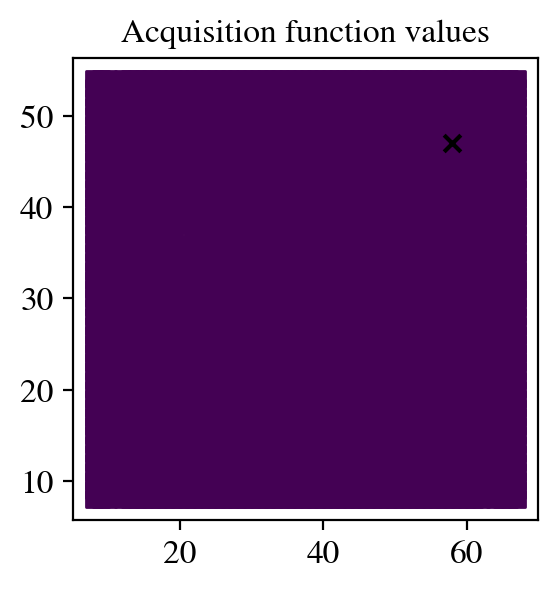

21/80


100%|██████████| 100/100 [00:01<00:00, 54.89it/s, init loss: 20150.5129, avg. loss [96-100]: 19062.9833]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3216
noise            0.0716


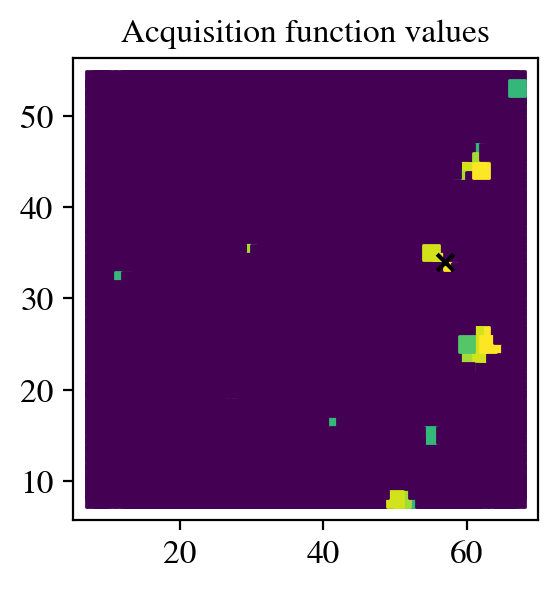

22/80


100%|██████████| 100/100 [00:01<00:00, 55.53it/s, init loss: 20151.7220, avg. loss [96-100]: 19062.7708]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3194
noise            0.0697


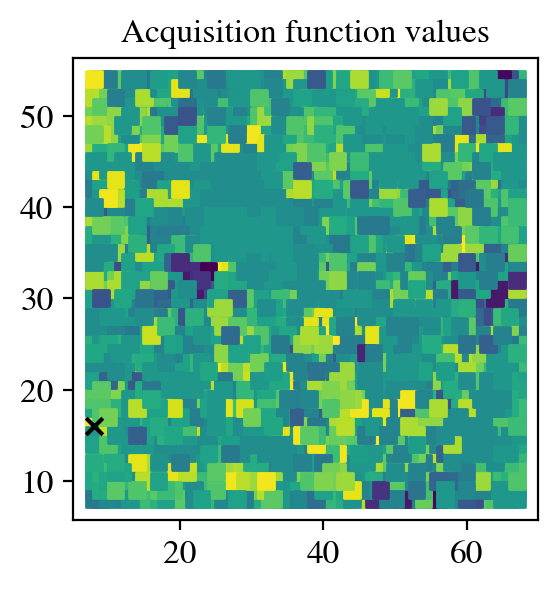

23/80


100%|██████████| 100/100 [00:01<00:00, 57.56it/s, init loss: 20152.9025, avg. loss [96-100]: 19062.3649]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.31920000000000004
noise            0.067


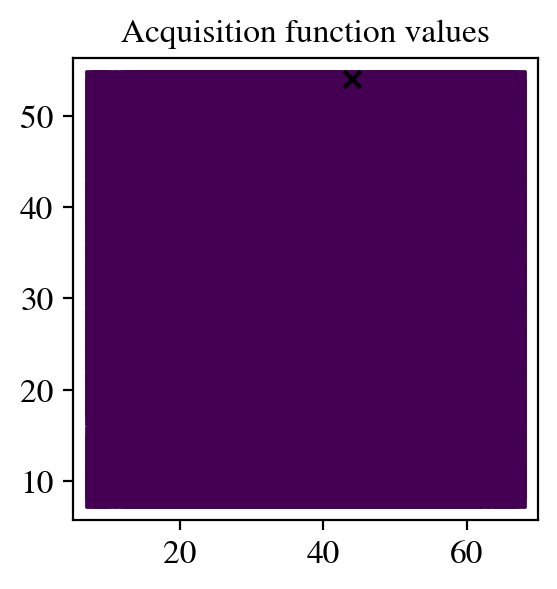

24/80


100%|██████████| 100/100 [00:01<00:00, 56.51it/s, init loss: 20154.1176, avg. loss [96-100]: 19081.0375]



Inferred GP kernel parameters
k_length         [2.2154 2.3325]
k_scale          0.2263
noise            0.034300000000000004


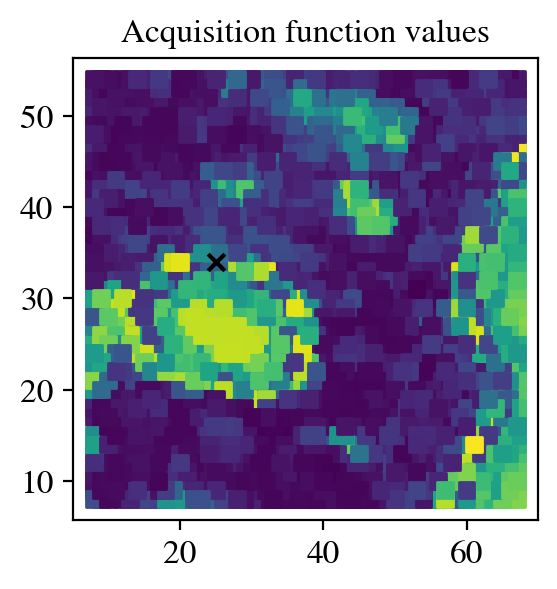

25/80


100%|██████████| 100/100 [00:04<00:00, 24.06it/s, init loss: 20155.5125, avg. loss [96-100]: 19063.1632]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.32030000000000003
noise            0.0702


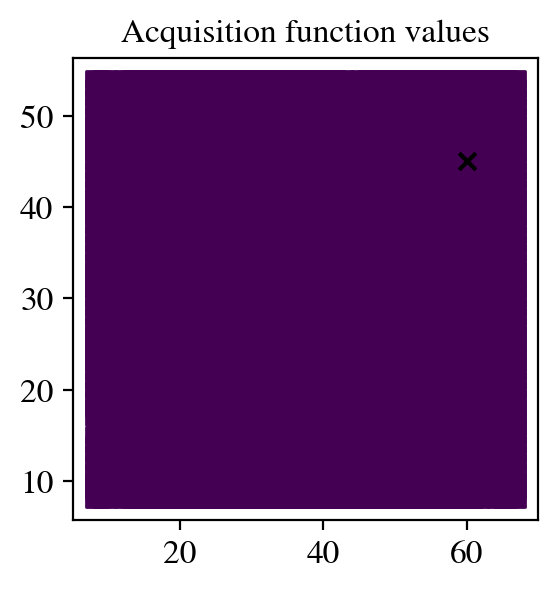

26/80


100%|██████████| 100/100 [00:02<00:00, 49.47it/s, init loss: 20156.6434, avg. loss [96-100]: 19063.2144]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.318
noise            0.07


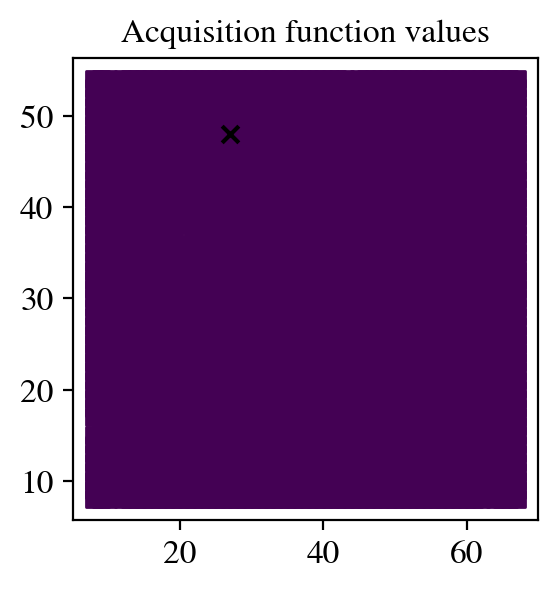

27/80


100%|██████████| 100/100 [00:01<00:00, 53.94it/s, init loss: 20157.8385, avg. loss [96-100]: 19063.1842]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.31520000000000004
noise            0.0695


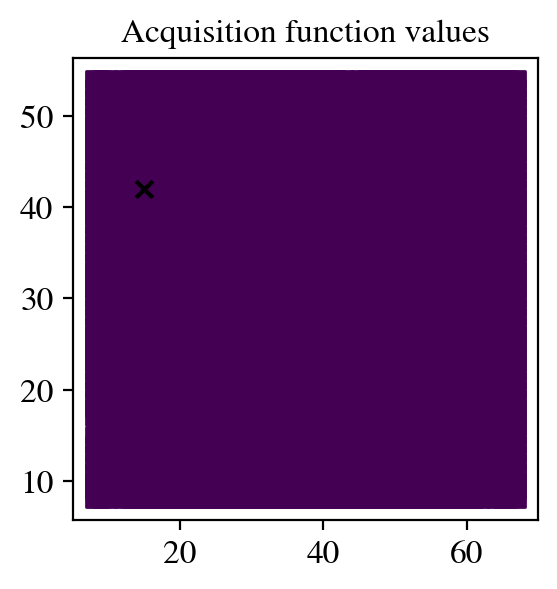

28/80


100%|██████████| 100/100 [00:02<00:00, 41.38it/s, init loss: 20159.0460, avg. loss [96-100]: 19080.7917]



Inferred GP kernel parameters
k_length         [2.4143 2.8353]
k_scale          0.21330000000000002
noise            0.028300000000000002


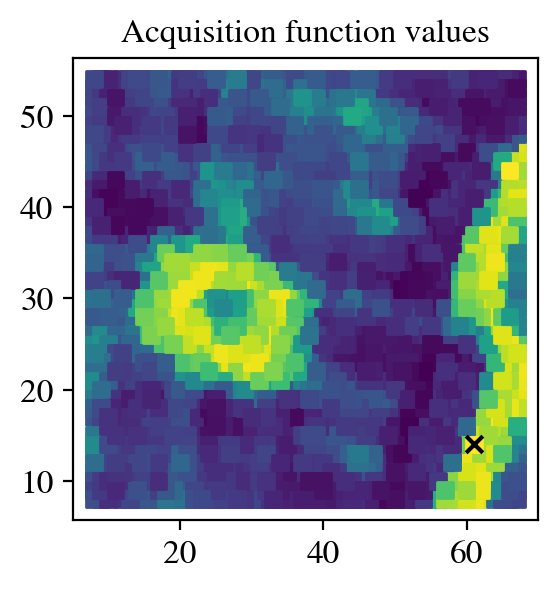

29/80


100%|██████████| 100/100 [00:01<00:00, 55.47it/s, init loss: 20160.3293, avg. loss [96-100]: 19088.6975]



Inferred GP kernel parameters
k_length         [3.1296 2.7542]
k_scale          0.19410000000000002
noise            0.0297


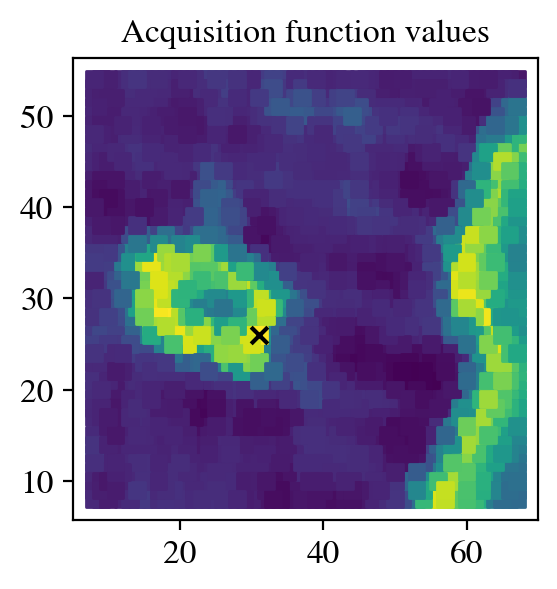

30/80


100%|██████████| 100/100 [00:01<00:00, 56.40it/s, init loss: 20161.7192, avg. loss [96-100]: 19102.2359]



Inferred GP kernel parameters
k_length         [3.3521 3.1973]
k_scale          0.1975
noise            0.029


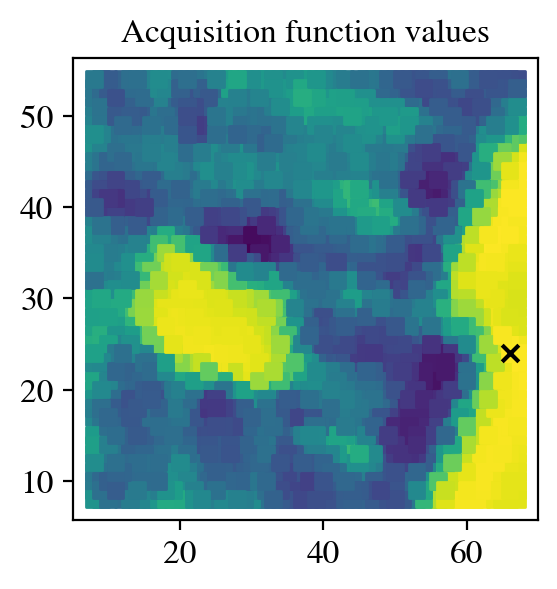

31/80


100%|██████████| 100/100 [00:02<00:00, 46.62it/s, init loss: 20163.0316, avg. loss [96-100]: 19102.4210]



Inferred GP kernel parameters
k_length         [2.0589 3.0953]
k_scale          0.2147
noise            0.0281


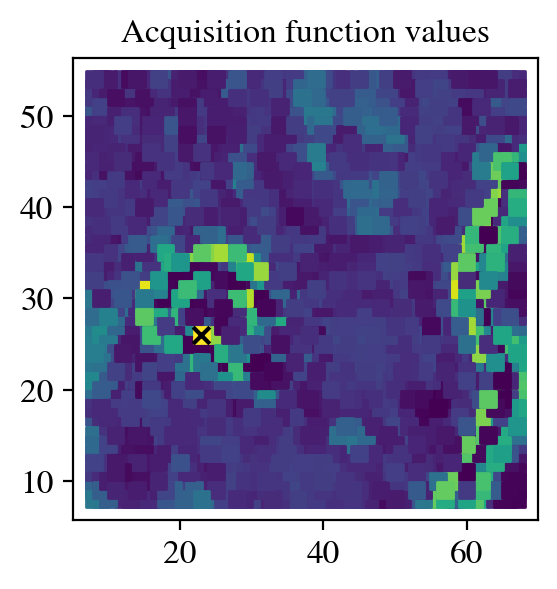

32/80


100%|██████████| 100/100 [00:01<00:00, 56.32it/s, init loss: 20164.2758, avg. loss [96-100]: 19112.8439]



Inferred GP kernel parameters
k_length         [4.9784 4.058 ]
k_scale          0.1905
noise            0.033100000000000004


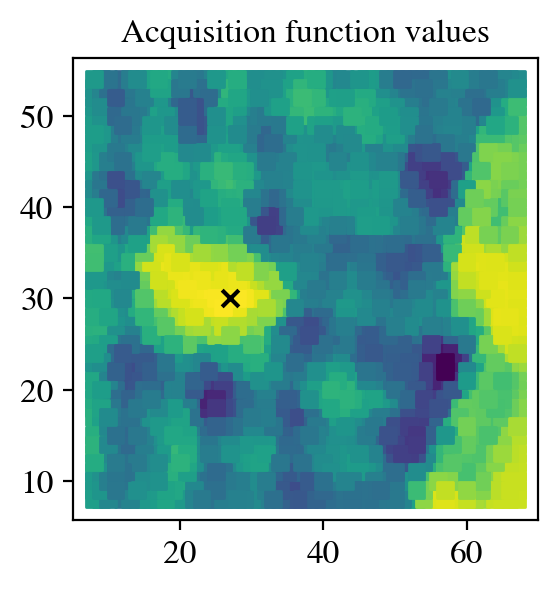

33/80


100%|██████████| 100/100 [00:01<00:00, 57.46it/s, init loss: 20165.5499, avg. loss [96-100]: 19084.5211]



Inferred GP kernel parameters
k_length         [2.4086 3.1864]
k_scale          0.23970000000000002
noise            0.027200000000000002


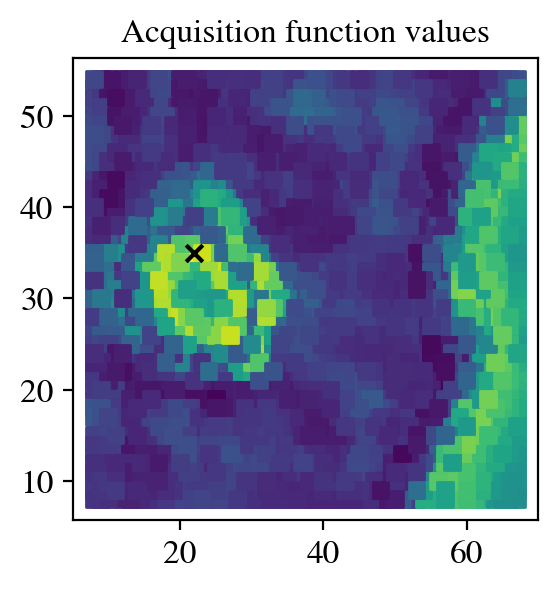

34/80


100%|██████████| 100/100 [00:02<00:00, 41.56it/s, init loss: 20166.9474, avg. loss [96-100]: 19123.9288]



Inferred GP kernel parameters
k_length         [2.9559 3.5711]
k_scale          0.22010000000000002
noise            0.0268


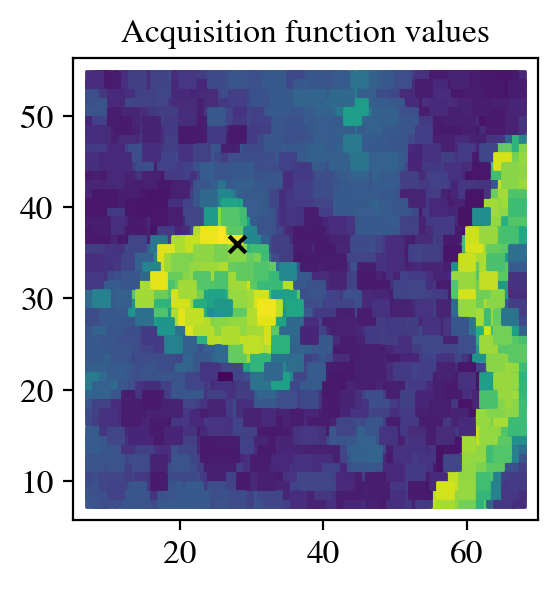

35/80


100%|██████████| 100/100 [00:01<00:00, 53.59it/s, init loss: 20168.1357, avg. loss [96-100]: 19125.9835]



Inferred GP kernel parameters
k_length         [4.0535 3.9264]
k_scale          0.2069
noise            0.0261


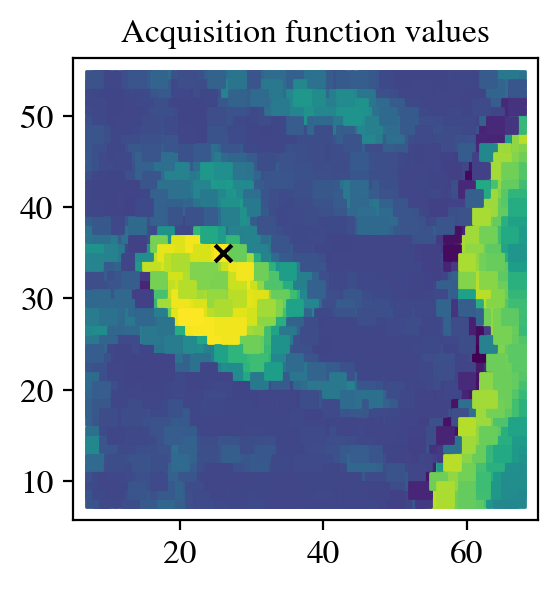

36/80


100%|██████████| 100/100 [00:01<00:00, 55.42it/s, init loss: 20169.3572, avg. loss [96-100]: 19109.4494]



Inferred GP kernel parameters
k_length         [4.243  3.6082]
k_scale          0.1978
noise            0.0304


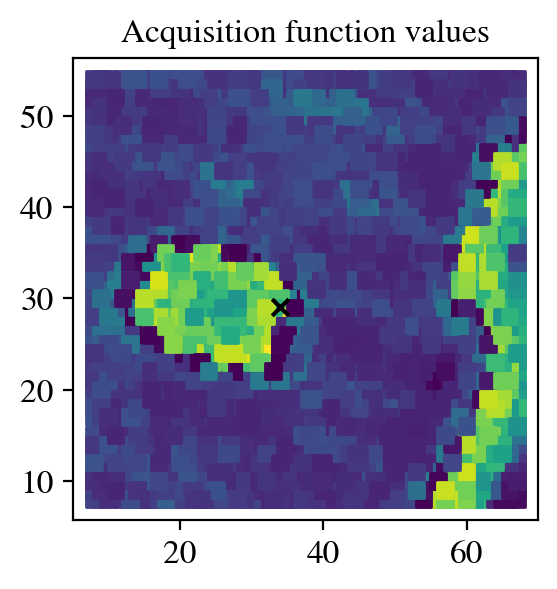

37/80


100%|██████████| 100/100 [00:02<00:00, 41.00it/s, init loss: 20170.6314, avg. loss [96-100]: 19084.4404]



Inferred GP kernel parameters
k_length         [3.6937 3.9663]
k_scale          0.2119
noise            0.0273


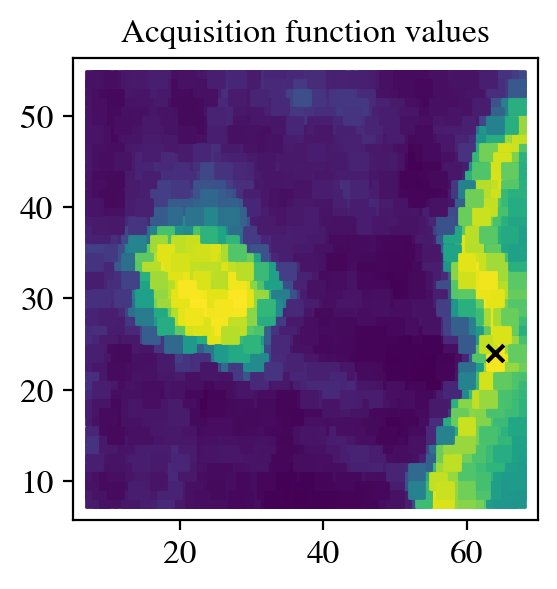

38/80


100%|██████████| 100/100 [00:02<00:00, 46.88it/s, init loss: 20171.8907, avg. loss [96-100]: 19086.6360]



Inferred GP kernel parameters
k_length         [4.9552 2.5858]
k_scale          0.2214
noise            0.0279


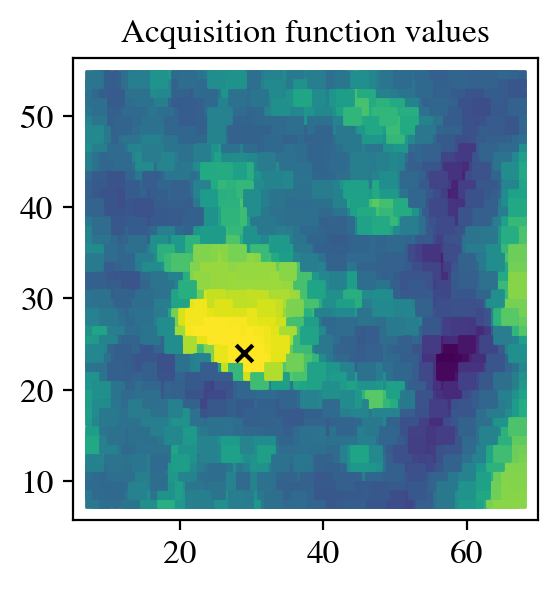

39/80


100%|██████████| 100/100 [00:01<00:00, 56.48it/s, init loss: 20173.2993, avg. loss [96-100]: 19118.0770]



Inferred GP kernel parameters
k_length         [4.5146 5.1299]
k_scale          0.2026
noise            0.0264


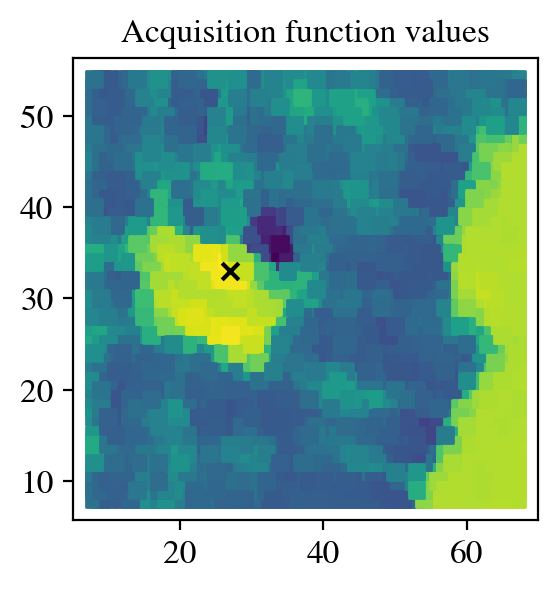

40/80


100%|██████████| 100/100 [00:01<00:00, 55.90it/s, init loss: 20174.7161, avg. loss [96-100]: 19112.8798]



Inferred GP kernel parameters
k_length         [3.7635 3.6714]
k_scale          0.201
noise            0.026600000000000002


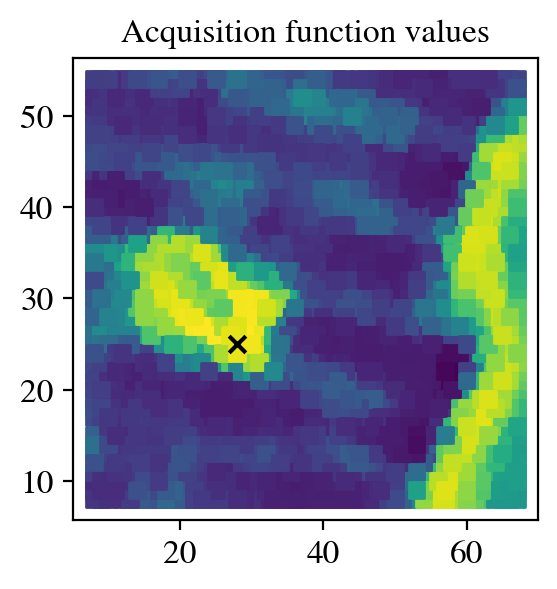

41/80


100%|██████████| 100/100 [00:02<00:00, 39.92it/s, init loss: 20176.1177, avg. loss [96-100]: 19111.2176]



Inferred GP kernel parameters
k_length         [4.2528 5.8147]
k_scale          0.2116
noise            0.027100000000000003


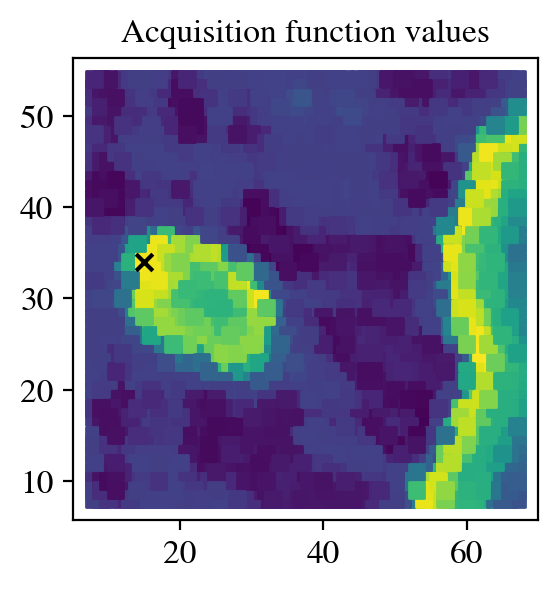

42/80


100%|██████████| 100/100 [00:01<00:00, 53.05it/s, init loss: 20177.4453, avg. loss [96-100]: 19099.0072]



Inferred GP kernel parameters
k_length         [4.5141 4.1935]
k_scale          0.2104
noise            0.0258


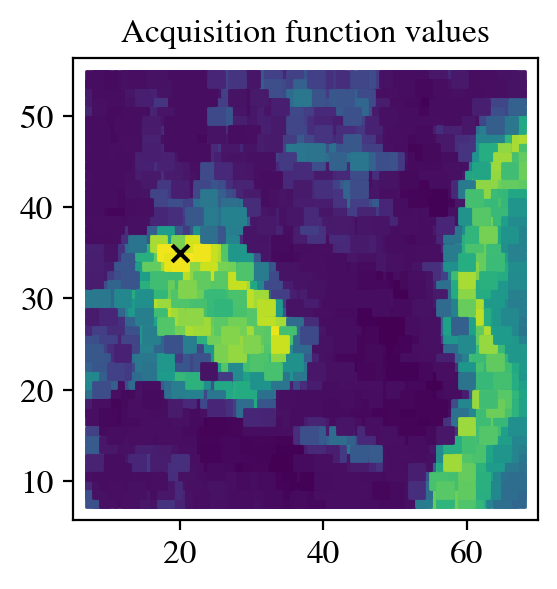

43/80


100%|██████████| 100/100 [00:01<00:00, 56.31it/s, init loss: 20178.7689, avg. loss [96-100]: 19067.2178]



Inferred GP kernel parameters
k_length         [5.0806 3.3434]
k_scale          0.1933
noise            0.0212


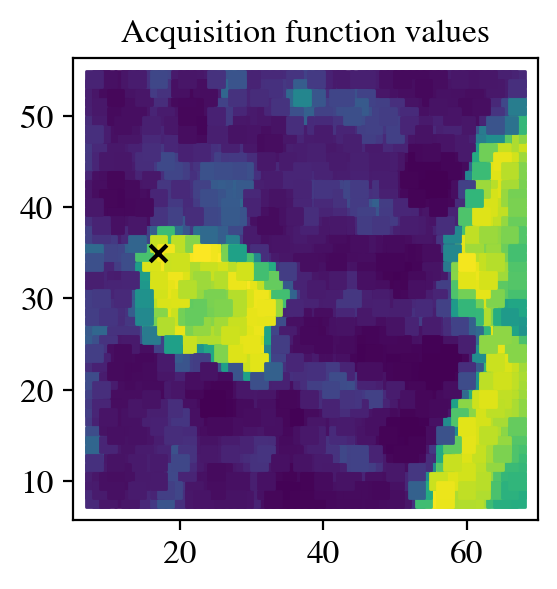

44/80


100%|██████████| 100/100 [00:02<00:00, 41.75it/s, init loss: 20180.0402, avg. loss [96-100]: 19091.3028]



Inferred GP kernel parameters
k_length         [3.5477 2.5465]
k_scale          0.2121
noise            0.0212


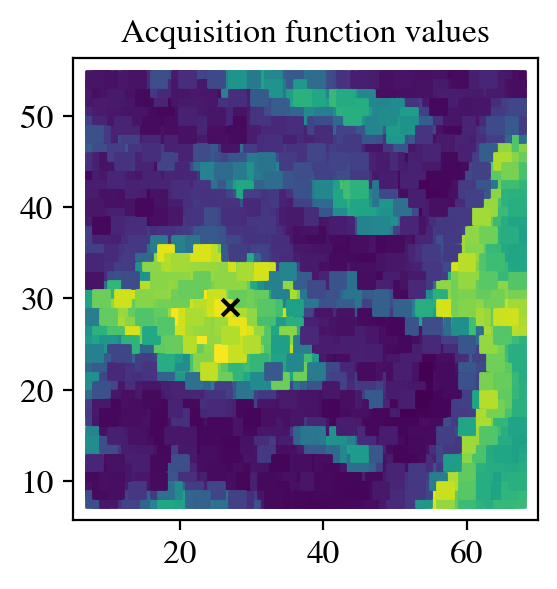

45/80


100%|██████████| 100/100 [00:01<00:00, 56.11it/s, init loss: 20181.3251, avg. loss [96-100]: 19063.3692]



Inferred GP kernel parameters
k_length         [3.3447 6.4554]
k_scale          0.2149
noise            0.021400000000000002


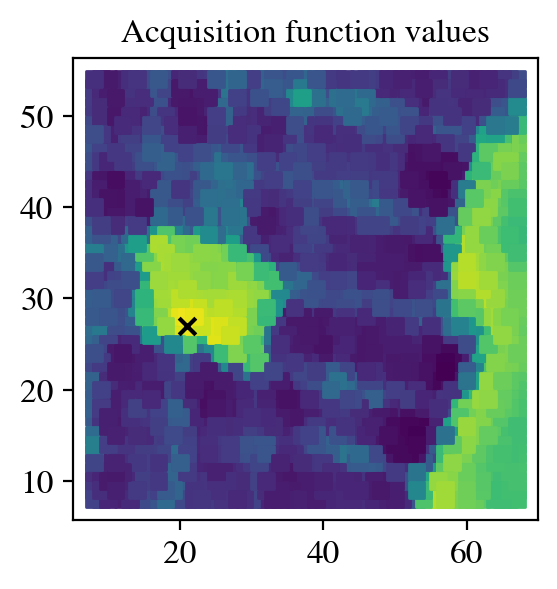

46/80


100%|██████████| 100/100 [00:01<00:00, 55.11it/s, init loss: 20182.5156, avg. loss [96-100]: 19097.1117]



Inferred GP kernel parameters
k_length         [5.9997 5.14  ]
k_scale          0.20320000000000002
noise            0.0241


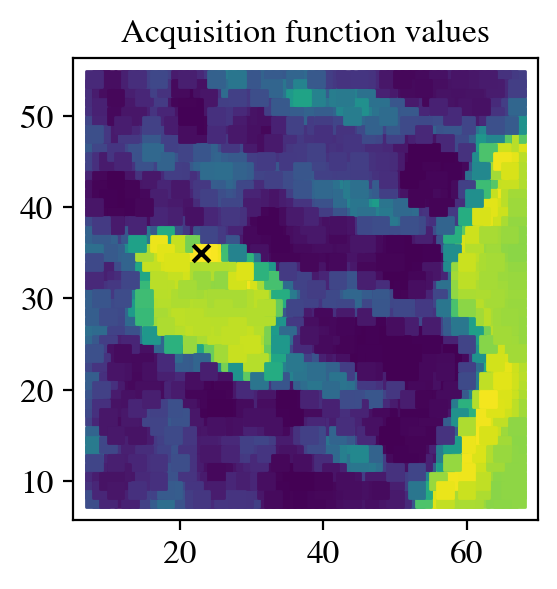

47/80


100%|██████████| 100/100 [00:02<00:00, 45.40it/s, init loss: 20183.8641, avg. loss [96-100]: 19065.3565]



Inferred GP kernel parameters
k_length         [4.1588 4.9654]
k_scale          0.218
noise            0.0216


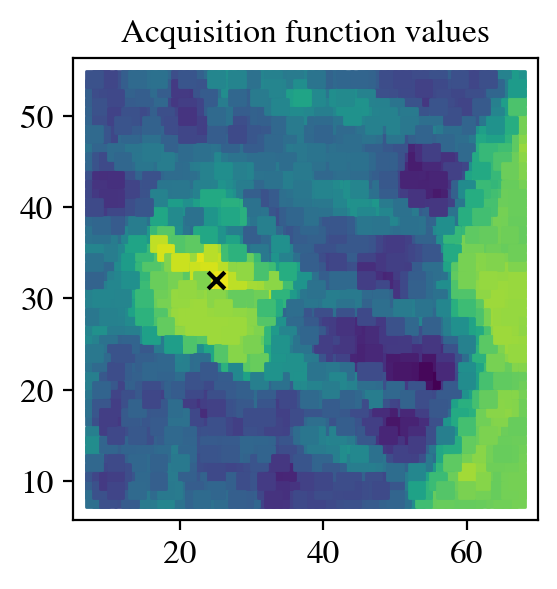

48/80


100%|██████████| 100/100 [00:01<00:00, 55.62it/s, init loss: 20185.2164, avg. loss [96-100]: 19140.3537]



Inferred GP kernel parameters
k_length         [5.7612 7.0589]
k_scale          0.2222
noise            0.0263


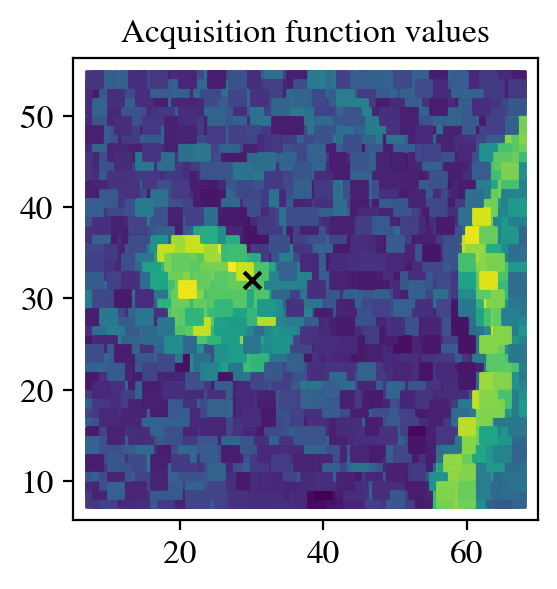

49/80


100%|██████████| 100/100 [00:01<00:00, 55.72it/s, init loss: 20186.4627, avg. loss [96-100]: 19134.7853]



Inferred GP kernel parameters
k_length         [6.4556 6.1924]
k_scale          0.17220000000000002
noise            0.024800000000000003


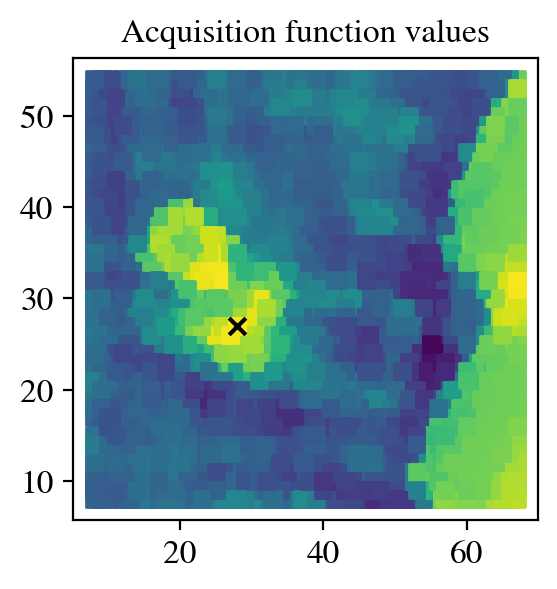

50/80


100%|██████████| 100/100 [00:02<00:00, 46.53it/s, init loss: 20187.7886, avg. loss [96-100]: 19128.4634]



Inferred GP kernel parameters
k_length         [5.6989 6.9809]
k_scale          0.1933
noise            0.0258


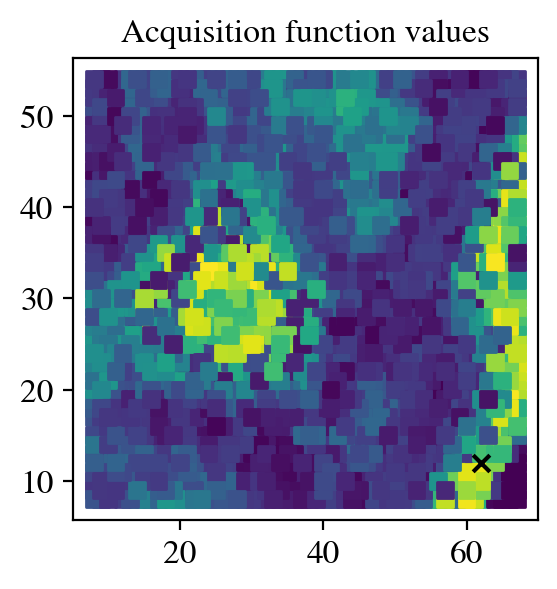

51/80


100%|██████████| 100/100 [00:01<00:00, 56.83it/s, init loss: 20188.9296, avg. loss [96-100]: 19070.0603]



Inferred GP kernel parameters
k_length         [5.4874 5.2806]
k_scale          0.2122
noise            0.020800000000000003


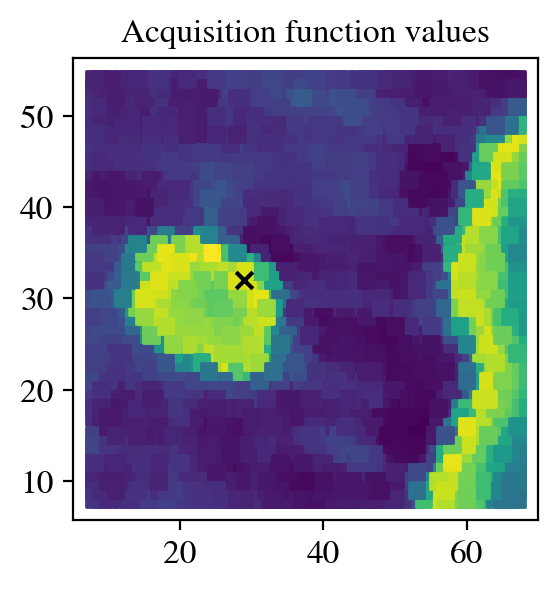

52/80


100%|██████████| 100/100 [00:01<00:00, 59.20it/s, init loss: 20190.3350, avg. loss [96-100]: 19126.3242]



Inferred GP kernel parameters
k_length         [6.545  3.9957]
k_scale          0.1951
noise            0.0239


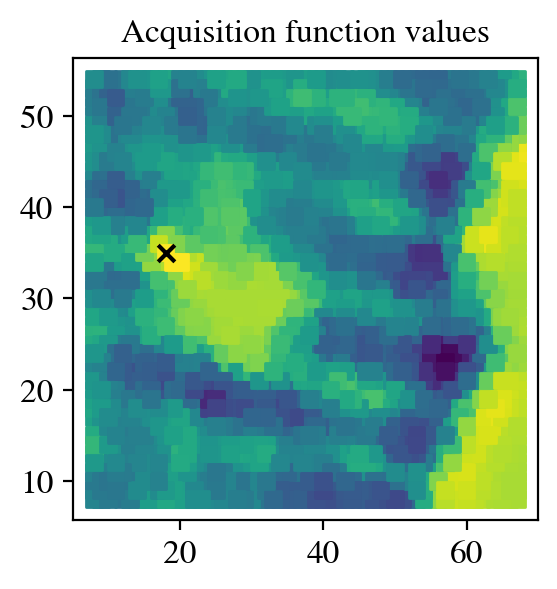

53/80


100%|██████████| 100/100 [00:01<00:00, 57.69it/s, init loss: 20191.5804, avg. loss [96-100]: 19084.2029]



Inferred GP kernel parameters
k_length         [11.9409  7.0417]
k_scale          0.1907
noise            0.0235


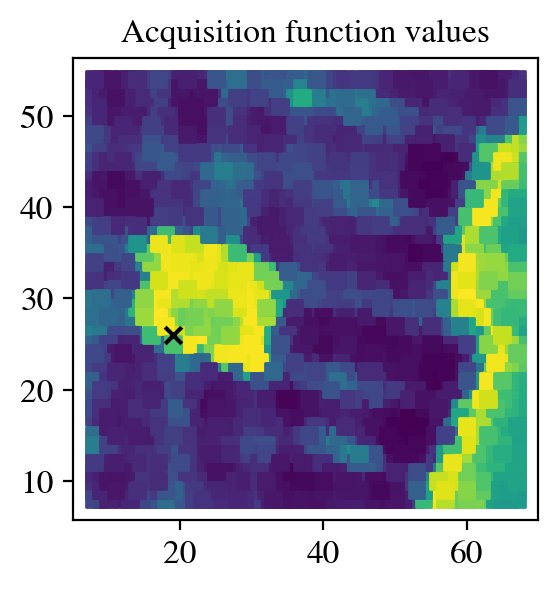

54/80


100%|██████████| 100/100 [00:01<00:00, 55.88it/s, init loss: 20192.8292, avg. loss [96-100]: 19094.9714]



Inferred GP kernel parameters
k_length         [6.8847 5.9432]
k_scale          0.2054
noise            0.020900000000000002


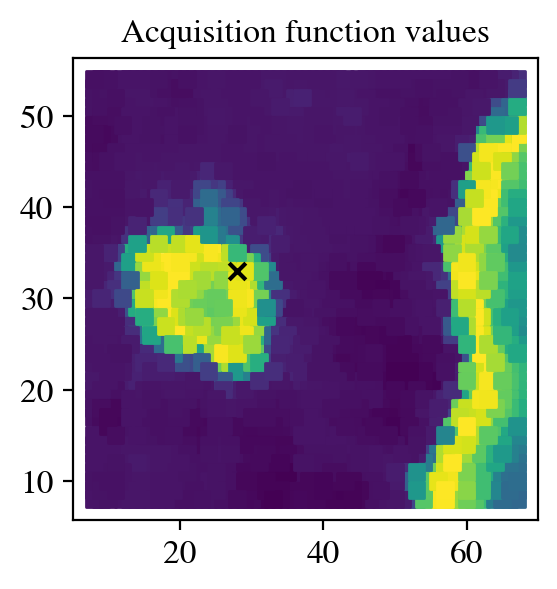

55/80


100%|██████████| 100/100 [00:01<00:00, 56.63it/s, init loss: 20194.0721, avg. loss [96-100]: 19111.3094]



Inferred GP kernel parameters
k_length         [7.2773 4.0799]
k_scale          0.185
noise            0.0198


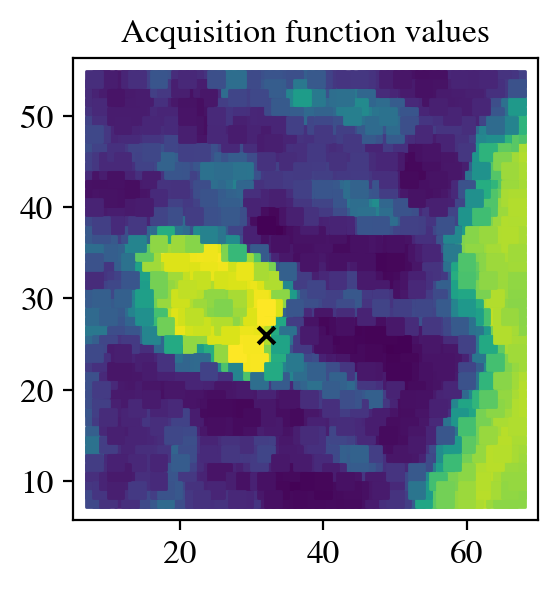

56/80


100%|██████████| 100/100 [00:01<00:00, 58.49it/s, init loss: 20195.4459, avg. loss [96-100]: 19093.9015]



Inferred GP kernel parameters
k_length         [6.9065 7.4233]
k_scale          0.1958
noise            0.022500000000000003


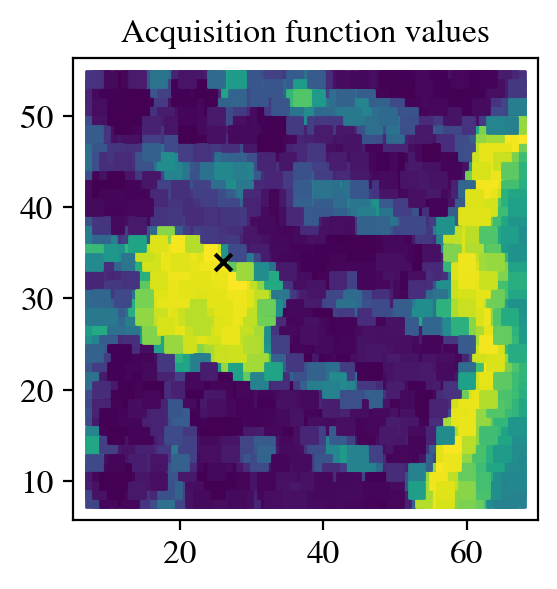

57/80


100%|██████████| 100/100 [00:01<00:00, 57.28it/s, init loss: 20196.7144, avg. loss [96-100]: 19041.4227]



Inferred GP kernel parameters
k_length         [4.2625 4.6645]
k_scale          0.23070000000000002
noise            0.0182


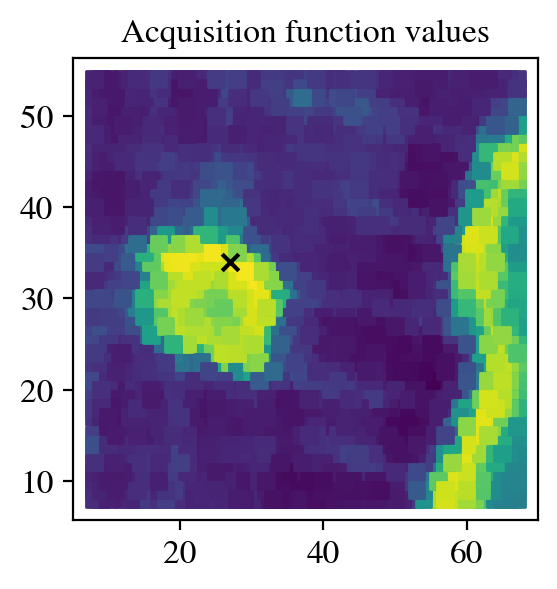

58/80


100%|██████████| 100/100 [00:01<00:00, 58.19it/s, init loss: 20198.0032, avg. loss [96-100]: 19070.9433]



Inferred GP kernel parameters
k_length         [9.5728 7.912 ]
k_scale          0.2069
noise            0.0224


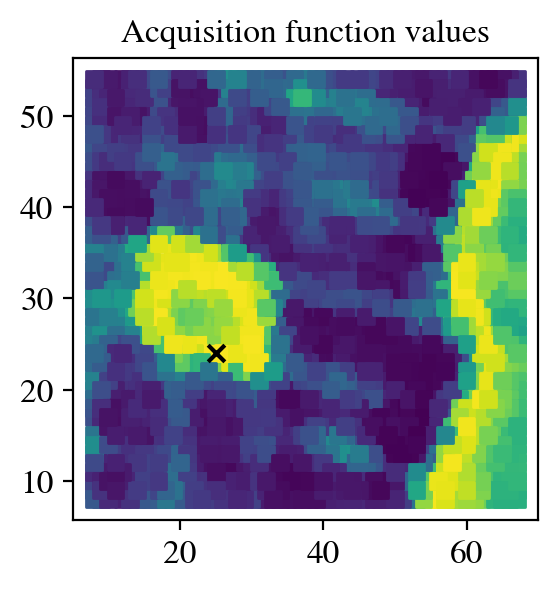

59/80


100%|██████████| 100/100 [00:01<00:00, 58.82it/s, init loss: 20199.3034, avg. loss [96-100]: 19112.2495]



Inferred GP kernel parameters
k_length         [5.1265 7.1823]
k_scale          0.2005
noise            0.018600000000000002


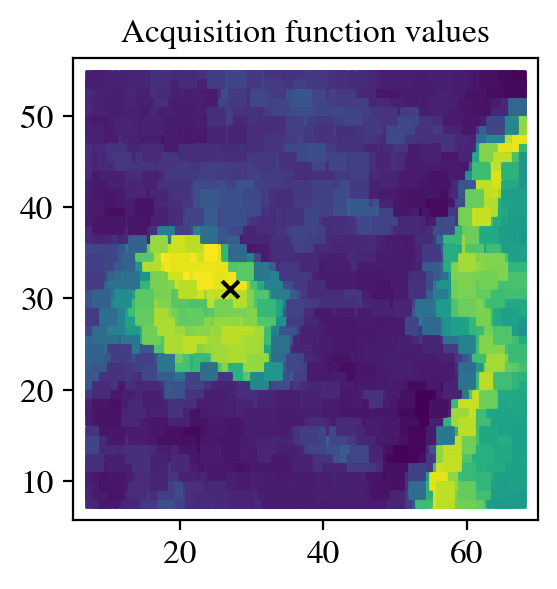

60/80


100%|██████████| 100/100 [00:01<00:00, 55.47it/s, init loss: 20200.5171, avg. loss [96-100]: 19104.2335]



Inferred GP kernel parameters
k_length         [7.6256 8.4223]
k_scale          0.16570000000000001
noise            0.02


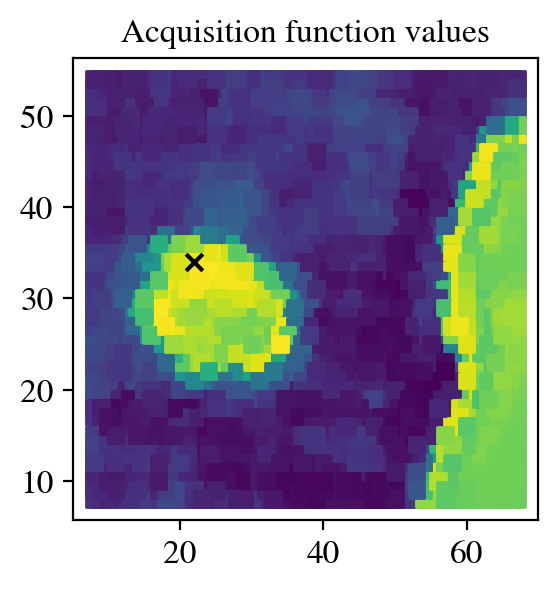

61/80


100%|██████████| 100/100 [00:01<00:00, 58.63it/s, init loss: 20201.9092, avg. loss [96-100]: 19093.1188]



Inferred GP kernel parameters
k_length         [7.93   5.7899]
k_scale          0.20550000000000002
noise            0.0199


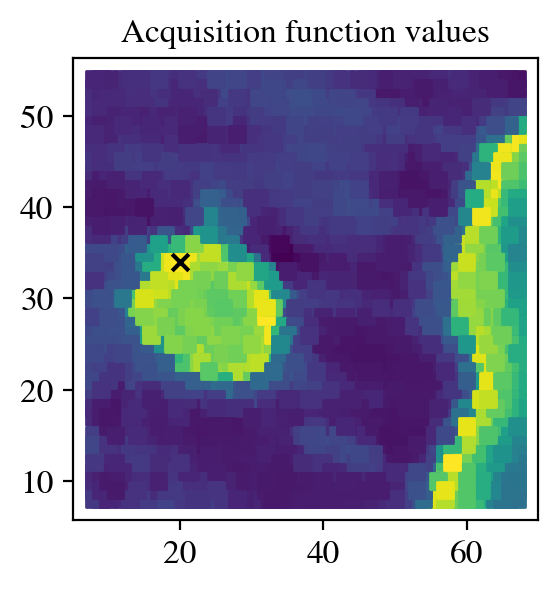

62/80


100%|██████████| 100/100 [00:01<00:00, 57.48it/s, init loss: 20203.1893, avg. loss [96-100]: 19067.5197]



Inferred GP kernel parameters
k_length         [7.6534 6.8652]
k_scale          0.19340000000000002
noise            0.020900000000000002


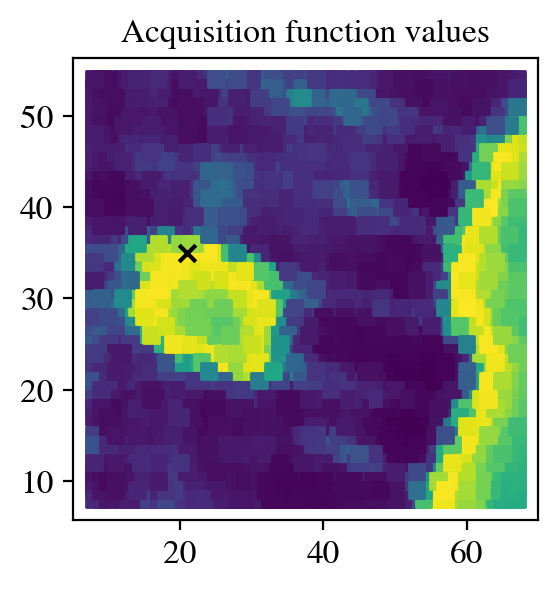

63/80


100%|██████████| 100/100 [00:01<00:00, 54.49it/s, init loss: 20204.4626, avg. loss [96-100]: 19065.7996]



Inferred GP kernel parameters
k_length         [6.8346 7.2502]
k_scale          0.2005
noise            0.019700000000000002


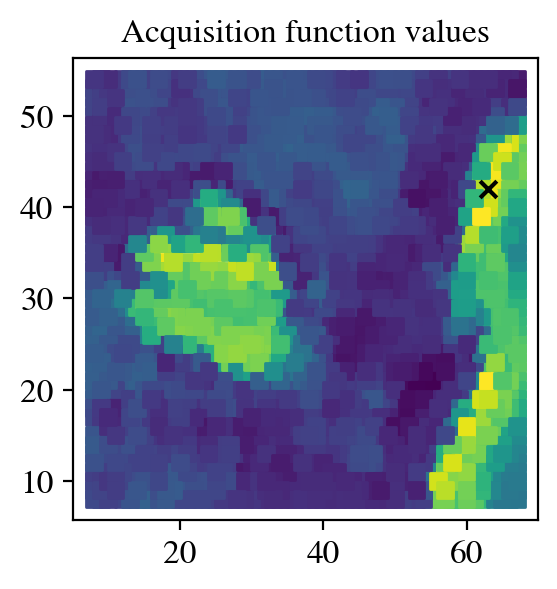

64/80


100%|██████████| 100/100 [00:01<00:00, 58.61it/s, init loss: 20205.6837, avg. loss [96-100]: 19080.9799]



Inferred GP kernel parameters
k_length         [6.6996 6.0748]
k_scale          0.18530000000000002
noise            0.0181


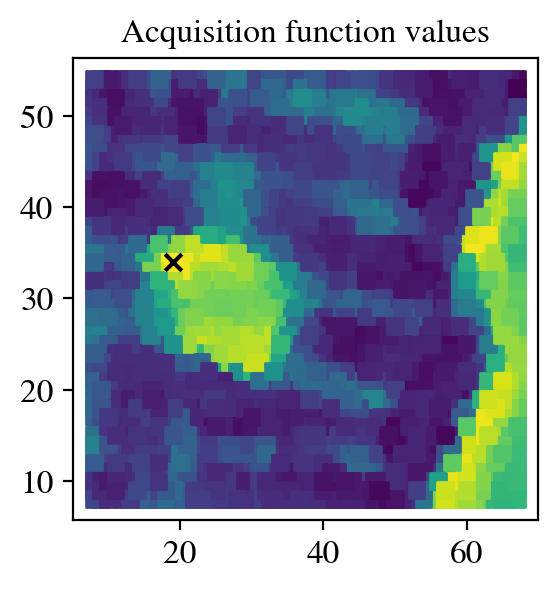

65/80


100%|██████████| 100/100 [00:01<00:00, 58.29it/s, init loss: 20206.9784, avg. loss [96-100]: 19128.8781]



Inferred GP kernel parameters
k_length         [7.2629 6.762 ]
k_scale          0.199
noise            0.0216


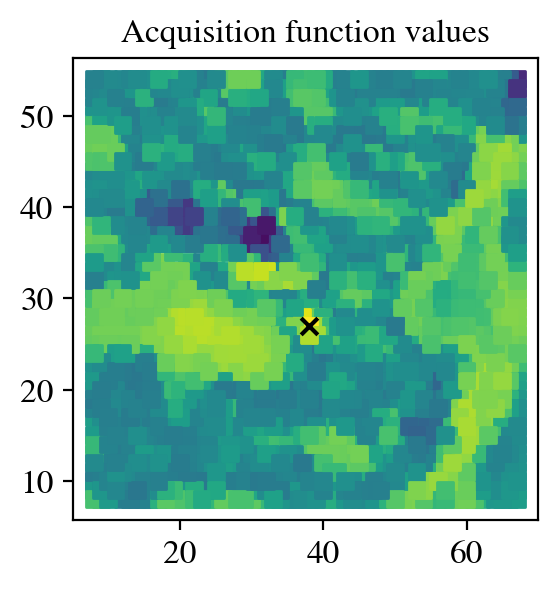

66/80


100%|██████████| 100/100 [00:03<00:00, 29.71it/s, init loss: 20208.2250, avg. loss [96-100]: 19136.5653]



Inferred GP kernel parameters
k_length         [7.8158 6.6933]
k_scale          0.19310000000000002
noise            0.0196


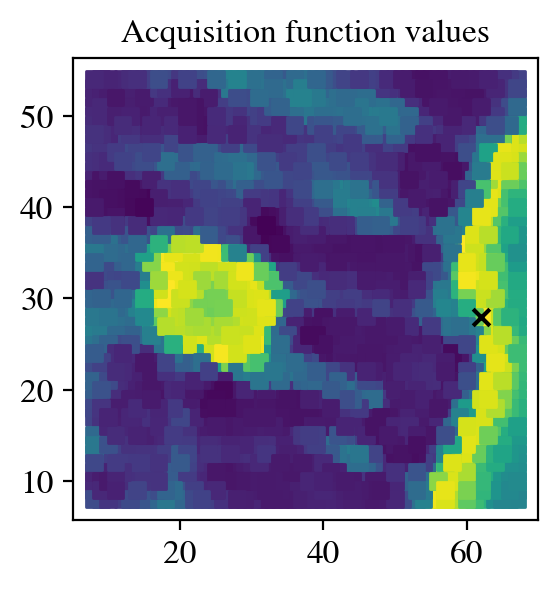

67/80


100%|██████████| 100/100 [00:01<00:00, 58.81it/s, init loss: 20209.5261, avg. loss [96-100]: 19050.0941]



Inferred GP kernel parameters
k_length         [5.5857 8.2466]
k_scale          0.2029
noise            0.0172


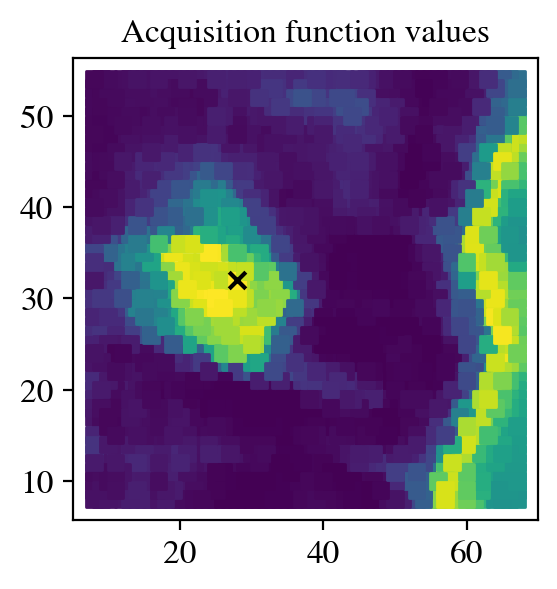

68/80


100%|██████████| 100/100 [00:01<00:00, 58.67it/s, init loss: 20210.7926, avg. loss [96-100]: 19109.9490]



Inferred GP kernel parameters
k_length         [6.0295 4.4168]
k_scale          0.1884
noise            0.0183


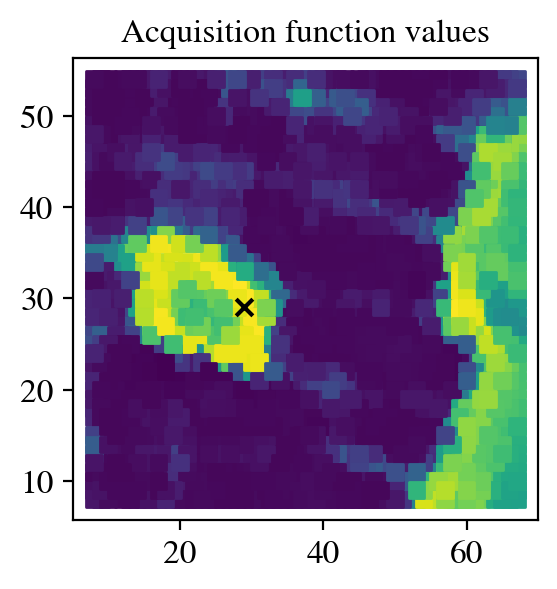

69/80


100%|██████████| 100/100 [00:02<00:00, 39.27it/s, init loss: 20212.0319, avg. loss [96-100]: 19165.5293]



Inferred GP kernel parameters
k_length         [8.3616 9.914 ]
k_scale          0.1804
noise            0.0196


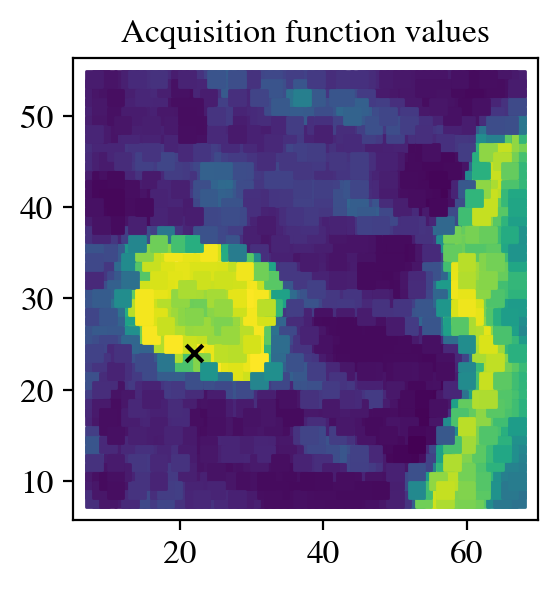

70/80


100%|██████████| 100/100 [00:01<00:00, 57.98it/s, init loss: 20213.2825, avg. loss [96-100]: 19076.9538]



Inferred GP kernel parameters
k_length         [5.997  8.3677]
k_scale          0.1962
noise            0.0201


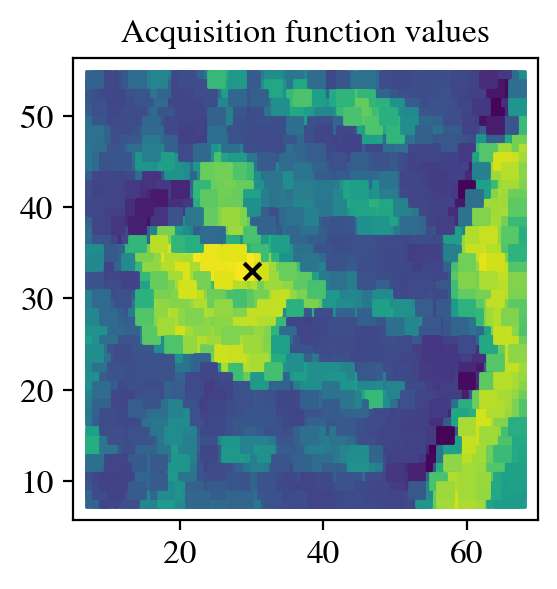

71/80


100%|██████████| 100/100 [00:01<00:00, 58.06it/s, init loss: 20214.4581, avg. loss [96-100]: 19071.7084]



Inferred GP kernel parameters
k_length         [12.5368 10.1599]
k_scale          0.1852
noise            0.0204


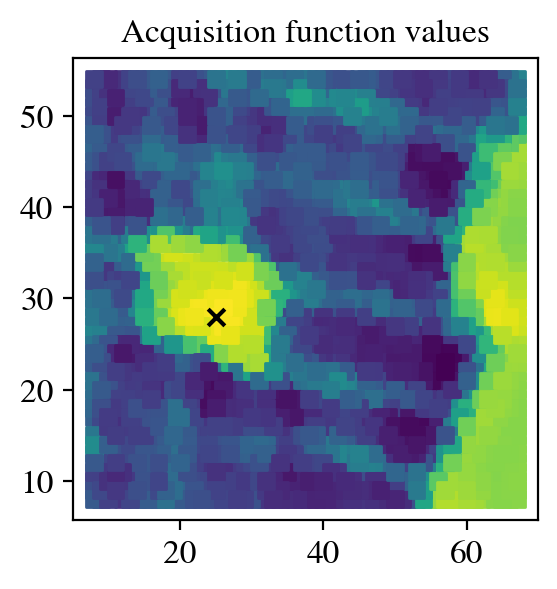

72/80


100%|██████████| 100/100 [00:02<00:00, 40.31it/s, init loss: 20215.7811, avg. loss [96-100]: 19145.3683]



Inferred GP kernel parameters
k_length         [8.9594 8.2377]
k_scale          0.1696
noise            0.018500000000000003


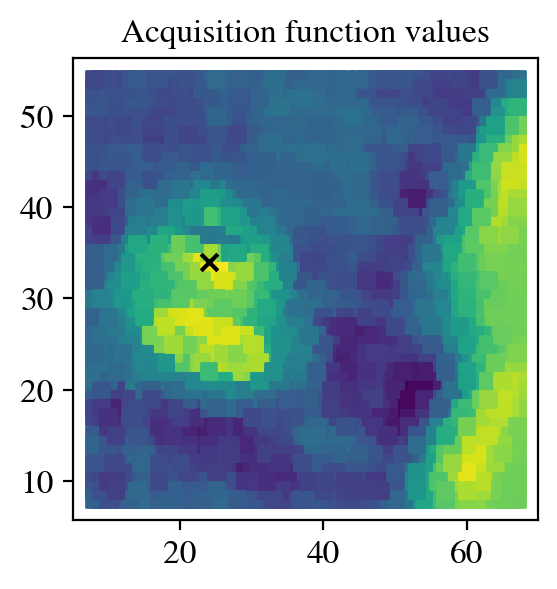

73/80


100%|██████████| 100/100 [00:01<00:00, 58.66it/s, init loss: 20216.9566, avg. loss [96-100]: 19052.7630]



Inferred GP kernel parameters
k_length         [6.1881 6.6538]
k_scale          0.2013
noise            0.017


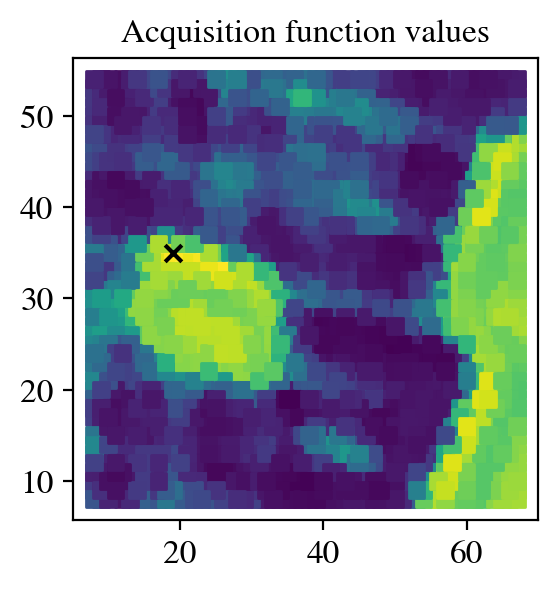

74/80


100%|██████████| 100/100 [00:01<00:00, 58.46it/s, init loss: 20218.1633, avg. loss [96-100]: 19115.7745]



Inferred GP kernel parameters
k_length         [11.4944 16.6495]
k_scale          0.1676
noise            0.0189


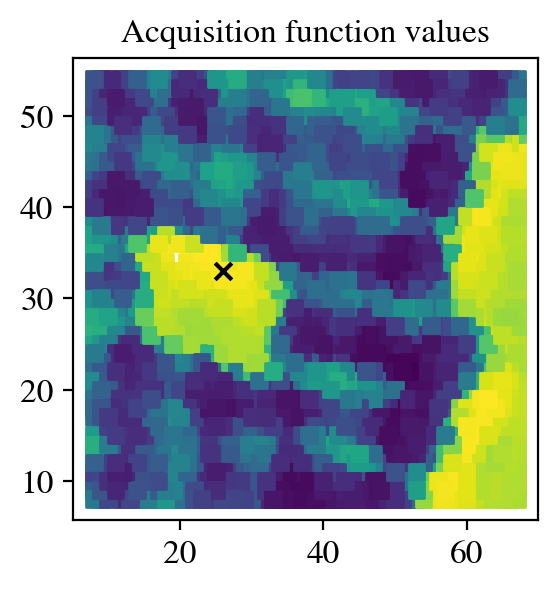

75/80


100%|██████████| 100/100 [00:01<00:00, 55.65it/s, init loss: 20219.4439, avg. loss [96-100]: 19132.5425]



Inferred GP kernel parameters
k_length         [8.24   7.3151]
k_scale          0.1784
noise            0.018600000000000002


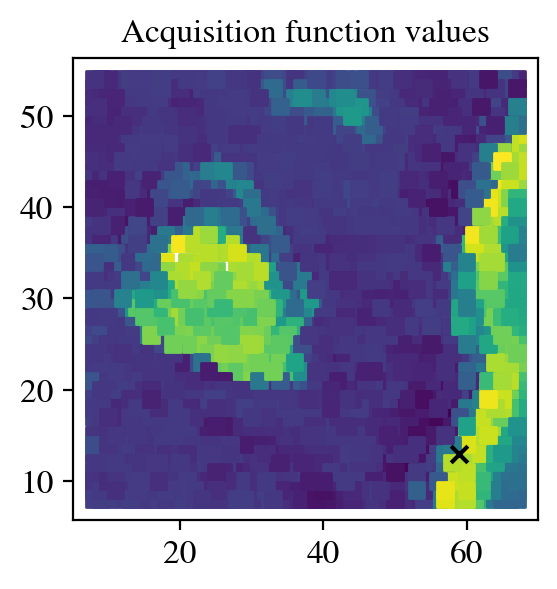

76/80


100%|██████████| 100/100 [00:01<00:00, 58.62it/s, init loss: 20220.8454, avg. loss [96-100]: 19132.7397]



Inferred GP kernel parameters
k_length         [11.7136 10.3391]
k_scale          0.17950000000000002
noise            0.0189


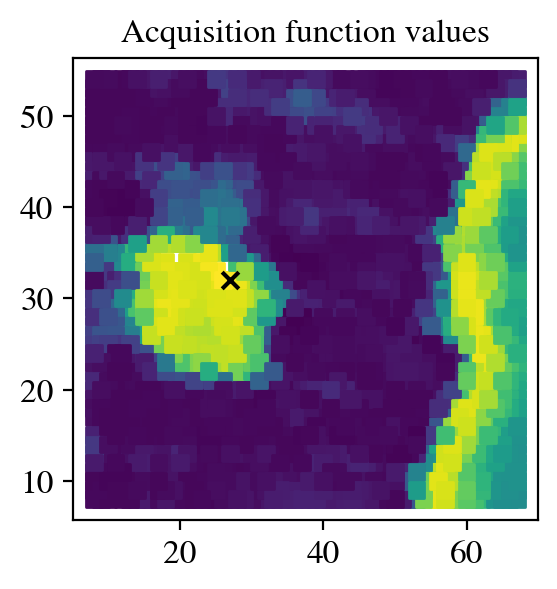

77/80


100%|██████████| 100/100 [00:01<00:00, 60.03it/s, init loss: 20222.0940, avg. loss [96-100]: 19062.5157]



Inferred GP kernel parameters
k_length         [4.0463 3.9376]
k_scale          0.223
noise            0.0188


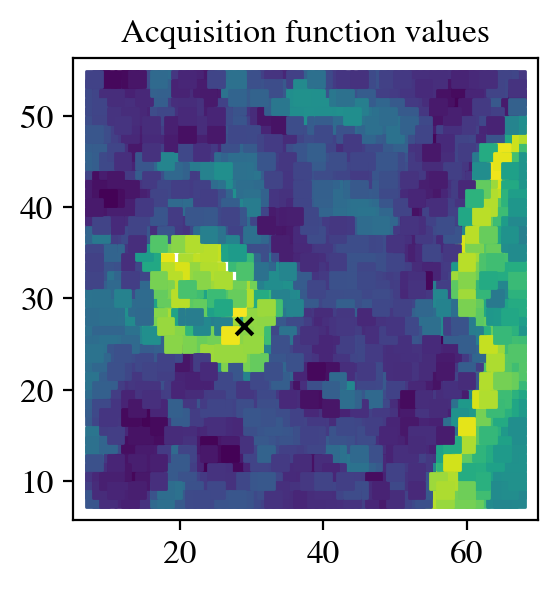

78/80


100%|██████████| 100/100 [00:01<00:00, 56.94it/s, init loss: 20223.2909, avg. loss [96-100]: 19028.8290]



Inferred GP kernel parameters
k_length         [7.6032 5.3062]
k_scale          0.1991
noise            0.0155


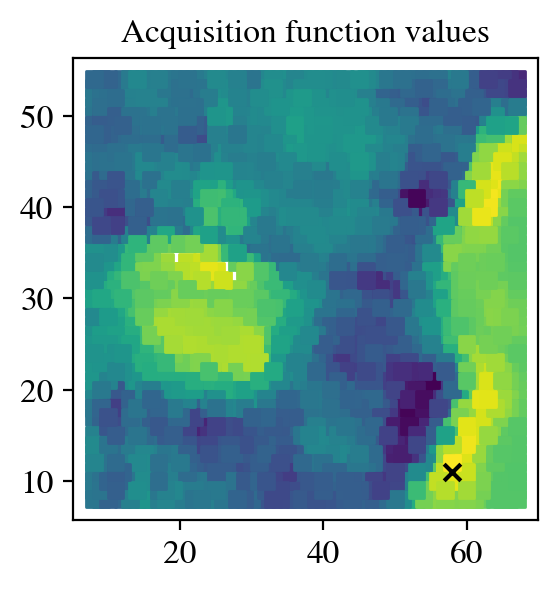

79/80


100%|██████████| 100/100 [00:01<00:00, 59.13it/s, init loss: 20224.5398, avg. loss [96-100]: 19110.6496]



Inferred GP kernel parameters
k_length         [6.4307 6.8608]
k_scale          0.17930000000000001
noise            0.0175


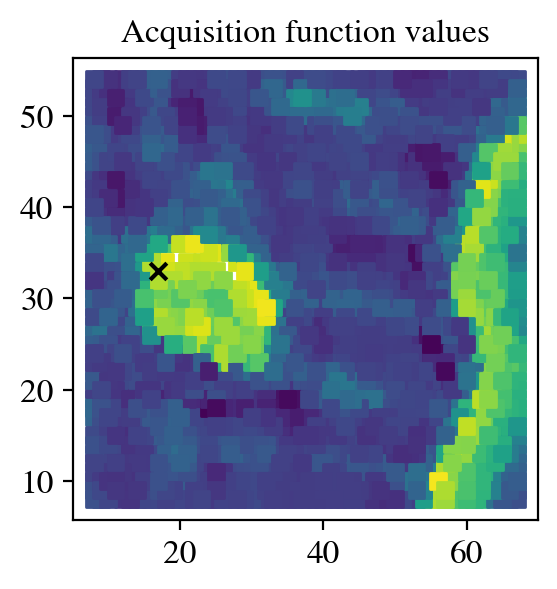

80/80


100%|██████████| 100/100 [00:01<00:00, 57.13it/s, init loss: 20225.8717, avg. loss [96-100]: 19063.2245]



Inferred GP kernel parameters
k_length         [10.0932 10.3632]
k_scale          0.1695
noise            0.0171


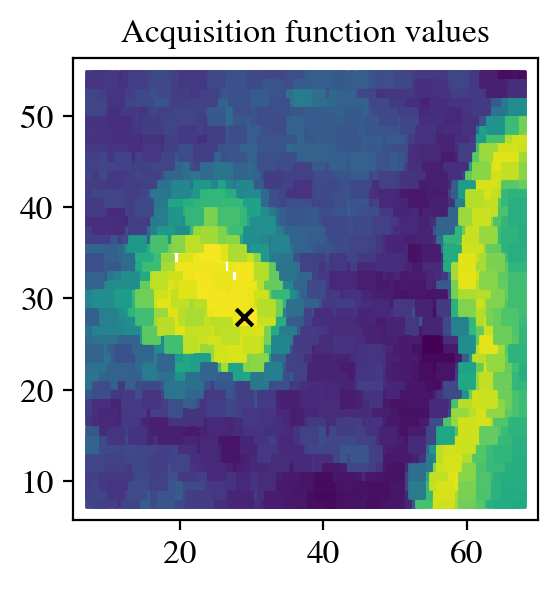

In [ ]:
data_dim = X_measured.shape[-1]

exploration_steps = 80 if not SMOKE else 5

key1, key2 = gpax.utils.get_keys()

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))

    # update GP posterior
    dkl = gpax.viDKL(data_dim, 2)

    # you may decrease step size and increase number of steps
    # (e.g. to 0.005 and 1000) for more stable performance
    dkl.fit(
        key1, X_measured, y_measured, num_steps=100, step_size=0.05
    )

    # Compute UCB acquisition function
    obj = gpax.acquisition.UCB(key2, dkl, X_unmeasured, beta=0.25, maximize=True)

    # Select next point to "measure"
    next_point_idx = obj.argmax()

    # Do "measurement"
    measured_point = y_unmeasured[next_point_idx]

    # Plot current result
    plot_result(indices_unmeasured, obj)

    # Update the arrays of measured/unmeasured points
    X_measured = np.append(X_measured, X_unmeasured[next_point_idx][None], 0)
    X_unmeasured = np.delete(X_unmeasured, next_point_idx, 0)
    y_measured = np.append(y_measured, measured_point)
    y_unmeasured = np.delete(y_unmeasured, next_point_idx)
    indices_measured = np.append(indices_measured, indices_unmeasured[next_point_idx][None], 0)
    indices_unmeasured = np.delete(indices_unmeasured, next_point_idx, 0)


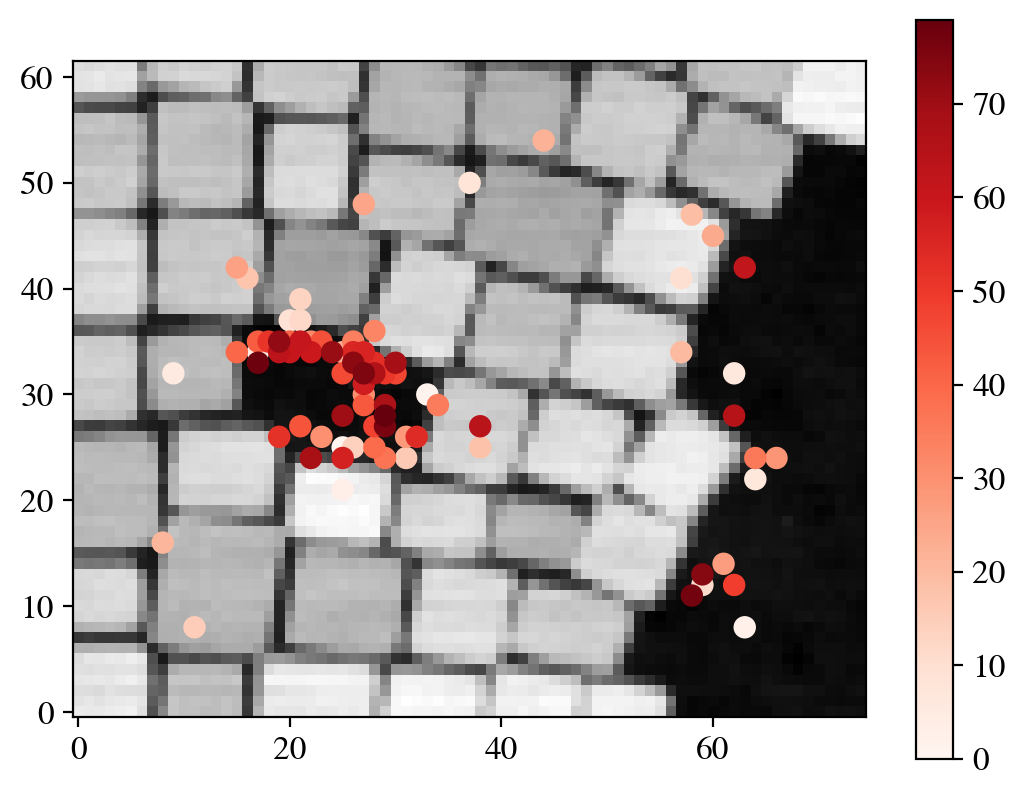

In [ ]:
plt.imshow(img, origin="lower", cmap='gray')
plt.scatter(
    indices_measured[seed_points:, 1],
    indices_measured[seed_points:, 0],
    c=np.arange(len(indices_measured[seed_points:])),
    s=50,
    cmap="Reds"
)
plt.colorbar()
plt.show()

Overlay with a 'ground truth':

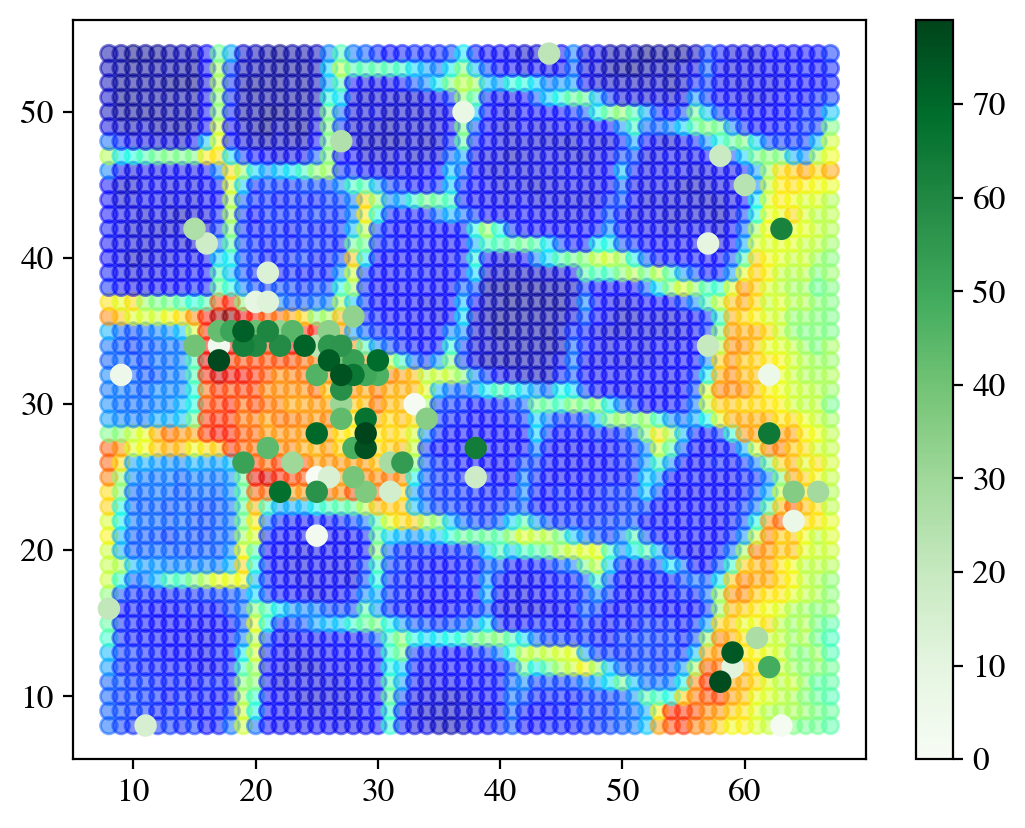

In [ ]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all, cmap='jet', alpha=0.5)
plt.scatter(
    indices_measured[seed_points:, 1],
    indices_measured[seed_points:, 0],
    c=np.arange(len(indices_measured[seed_points:])),
    s=50,
    cmap="Greens"
)
plt.colorbar()
plt.show()

Looks like it did a pretty good job identifying the regions where a physical behavior of interest is maximized.